# Import

In [804]:
import numpy as np
import pandas as pd
import math, itertools
from itertools import combinations, product

from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objects as go
from plotly.colors import sample_colorscale

from scipy.optimize import linprog
import torch, torch.nn.functional as F

# Toy Case

## Checking Inequalities

| **column in the DataFrame** | **what it measures**                                                                      | **inequality it should satisfy** |
| --------------------------- | ----------------------------------------------------------------------------------------- | -------------------------------- |
| `max_diff_over_grad`        | $\displaystyle\max_{x'}\frac{\lvert\psi(x')-\psi(x)\rvert}{\sqrt2\,\|J\|_2\,\|x'-x\|_2}$ | ≤ 1                              |
| `max_grad_over_Li`          | $\displaystyle\max_{x'}\frac{\sqrt2\,\|J\|_2\,\|x'-x\|_2}{L_i\,\|x'-x\|_2}$              | ≤ 1                              |
| `max_diff_over_Li`          | $\displaystyle\max_{x'}\frac{\lvert\psi(x')-\psi(x)\rvert}{L_i\,\|x'-x\|_2}$             | ≤ 1                              |


In [2]:
def spec_norm(M):
    return np.linalg.svd(M, compute_uv=False)[0]

def psi(x, y, W1, W2):
    z = W2 @ np.maximum(W1 @ x, 0.)
    p = np.exp(z - z.max()); p /= p.sum()
    return -np.log((p * y).sum())

def run(seed, n=4, n1=3, K=3,
        trials=400, noise=0.7):
    rng = np.random.default_rng(seed)

    # network
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K,  n1))

    # base sample
    x = rng.standard_normal(n)
    y = np.array([0.,1.,0.])

    # Jacobian norm at x
    D  = np.diag((W1 @ x) > 0)
    J  = W2 @ D @ W1
    Jn = spec_norm(J)

    # global Lipschitz constant
    masks = np.array(np.meshgrid([0,1],[0,1],[0,1])).T.reshape(-1,3)
    L_i   = np.sqrt(2) * max(spec_norm(W2 @ np.diag(m) @ W1) for m in masks)

    r1 = r2 = r3 = 0.0
    for _ in range(trials):
        x_p = x + noise * rng.standard_normal(n)
        d   = np.linalg.norm(x_p - x)
        if d == 0: continue

        diff   = abs(psi(x_p, y, W1, W2) - psi(x, y, W1, W2))
        bound1 = np.sqrt(2) * Jn * d
        bound2 = L_i * d

        r1 = max(r1, diff / bound1)   # should ≤ 1
        r2 = max(r2, bound1 / bound2) # should ≤ 1
        r3 = max(r3, diff / bound2)   # should ≤ 1

    return dict(seed=seed, J_norm=Jn, L_i=L_i,
                max_diff_over_grad=r1,
                max_grad_over_Li=r2,
                max_diff_over_Li=r3)

df = pd.DataFrame([run(s) for s in range(5)])
df

,seed,J_norm,L_i,max_diff_over_grad,max_grad_over_Li,max_diff_over_Li
0,0,2.953623,4.177054,0.734026,1.000000,0.734026
1,1,1.983684,2.805353,0.062318,1.000000,0.062318
2,2,1.402538,5.058292,1.078396,0.392126,0.422867
3,3,4.276725,6.048203,0.724672,1.000000,0.724672
4,4,6.219832,9.575248,0.151276,0.918636,0.138968


| column name in the DataFrame| what the numbers are|
|---------------------------- | ------------------- |
| `ratio_single`| $\displaystyle\frac{\lvert\psi(x')-\psi(x)\rvert}{\sqrt2\,\|J\|_2\,\|x'-x\|_2}$|
| `ratio_path`| $\displaystyle\frac{\lvert\psi(x')-\psi(x)\rvert}{\sqrt2\,\|J^{(*)}\|_2\,\|x'-x\|_2}$ |
| `ratio_Li`| $\displaystyle\frac{\lvert\psi(x')-\psi(x)\rvert}{L_i\,\|x'-x\|_2}$|
| `n_segs`| how many linear **segments** the straight path $x \to x'$ was broken into|


In [3]:
# --- hyper-parameters ---
n, n1, K  = 4, 3, 3       # dims
N_pairs   = 200           # how many x′ to test
grid_pts  = 300           # samples along [0,1] to detect mask changes
rng       = np.random.default_rng(0)

# --- helper: spectral 2-norm ---
spec = lambda M: np.linalg.svd(M, compute_uv=False)[0]

# --- build one random network + anchor sample (x,y) ---
W1 = rng.standard_normal((n1, n))
W2 = rng.standard_normal((K , n1))
x  = rng.standard_normal(n)
y  = np.eye(K)[1]                # one-hot label “class 1”

# Jacobian and mask at the anchor point
a1   = W1 @ x
D0   = np.diag(a1 > 0)
J0   = W2 @ D0 @ W1
J0_n = spec(J0)

# global Lipschitz constant  L_i = √2 max_D ‖W2DW1‖
masks = np.array(np.meshgrid([0,1],[0,1],[0,1])).T.reshape(-1,3)
L_i   = np.sqrt(2)*max(spec(W2 @ np.diag(m) @ W1) for m in masks)

def psi(x_vec):
    z = W2 @ np.maximum(W1 @ x_vec, 0.)
    p = np.exp(z - z.max()); p /= p.sum()
    return -np.log(p[1])          # class-1 CE loss

records = []

for _ in range(N_pairs):
    x_p = x + rng.standard_normal(n)          # new target x′
    diff = abs(psi(x_p) - psi(x))
    dist = np.linalg.norm(x_p - x)

    # --- single-cell bound (should hold if x′ stays in same mask) ---
    b_single = np.sqrt(2)*J0_n*dist
    ratio_single = diff / b_single

    # --- pathwise bound (follow straight line, detect mask flips) ---
    ts = np.linspace(0,1,grid_pts+1)
    seg_masks, seg_Jnorm, seg_len = [], [], []

    last_t, last_x = 0.0, x
    last_mask = (W1 @ last_x > 0)

    for t in ts[1:]:
        xx = x + t*(x_p - x)
        mask = (W1 @ xx > 0)
        if not np.array_equal(mask, last_mask):  # boundary crossed
            seg_masks.append(last_mask)
            seg_Jnorm.append(spec(W2 @ np.diag(last_mask) @ W1))
            seg_len.append(np.linalg.norm(xx - last_x))
            last_t, last_x, last_mask = t, xx, mask

    # include final tiny segment (if any)
    if last_t < 1.0:
        seg_masks.append(last_mask)
        seg_Jnorm.append(spec(W2 @ np.diag(last_mask) @ W1))
        seg_len.append(np.linalg.norm(x_p - last_x))

    Jmax = max(seg_Jnorm)
    path_bound = np.sqrt(2)*Jmax*sum(seg_len)
    ratio_path = diff / path_bound
    ratio_Li   = diff / (L_i*dist)

    records.append(dict(diff=diff,
                        dist=dist,
                        ratio_single=ratio_single,
                        ratio_path=ratio_path,
                        ratio_Li=ratio_Li,
                        n_segs=len(seg_len)))

pd.DataFrame(records).describe()[["ratio_single","ratio_path","ratio_Li","n_segs"]]


,ratio_single,ratio_path,ratio_Li,n_segs
count,200.000000,200.000000,200.000000,200.000000
mean,0.178067,0.178067,0.178067,2.055000
std,0.179381,0.179381,0.179381,1.003499
min,0.001704,0.001704,0.001704,1.000000
25%,0.048484,0.048484,0.048484,1.000000
50%,0.092309,0.092309,0.092309,2.000000
75%,0.260301,0.260301,0.260301,3.000000
max,0.704814,0.704814,0.704814,4.000000


| column                       | what it is|
| ---------------------------- | ------------------------------------------                         |
| **`‖W2‖₂·‖W1‖₂`**            | product of the *individual* spectral norms                         |                
| **`‖W2·W1‖₂`**               | spectral norm of the *full* linear map $W_2W_1$ (no ReLU masking)  |
| **`max‖W2·D·W1‖₂`**          | largest norm over all $2^{\,n_1}$ binary masks $D$                 |
| **`min‖W2·D·W1‖₂`**          | smallest masked norm                                               |
| **`ratio (max / prod)`**     | $\dfrac{\text{max‖W2DW1‖₂}}{\|W_2\|_2\|W_1\|_2}$                   |
| **`ratio (max / full)`**     | $\dfrac{\text{max‖W2DW1‖₂}}{\|W_2W_1\|_2}$                         |


In [4]:
def spec_norm(M):
    """Spectral (operator-2) norm."""
    return np.linalg.svd(M, compute_uv=False)[0]

def compare_norms(seed, n=4, n1=3, K=3):
    rng = np.random.default_rng(seed)
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K,  n1))

    # individual layer norms
    norm_W1 = spec_norm(W1)
    norm_W2 = spec_norm(W2)
    prod_norm = norm_W1 * norm_W2          # ‖W2‖₂ · ‖W1‖₂

    # full linear map
    full_norm = spec_norm(W2 @ W1)         # ‖W2·W1‖₂

    # enumerate every binary mask D  (2^{n1} masks for small n1)
    masks = np.array(np.meshgrid(*[[0, 1]] * n1)).T.reshape(-1, n1)
    mask_norms = [spec_norm(W2 @ np.diag(m) @ W1) for m in masks]
    max_mask = max(mask_norms)
    min_mask = min(mask_norms)

    return {
        "seed": seed,
        "‖W2‖₂·‖W1‖₂": prod_norm,
        "‖W2·W1‖₂": full_norm,
        "max‖W2·D·W1‖₂": max_mask,
        "min‖W2·D·W1‖₂": min_mask,
        "ratio (max / prod)": max_mask / prod_norm,
        "ratio (max / full)": max_mask / full_norm if full_norm else np.nan
    }

# run for a few random seeds
df = pd.DataFrame(compare_norms(s) for s in range(5))
df

,seed,‖W2‖₂·‖W1‖₂,‖W2·W1‖₂,max‖W2·D·W1‖₂,min‖W2·D·W1‖₂,ratio (max / prod),ratio (max / full)
0,0,5.539950,2.809167,2.953623,0.0,0.533150,1.051423
1,1,2.128710,1.960581,1.983684,0.0,0.931872,1.011784
2,2,4.894370,3.544063,3.576753,0.0,0.730789,1.009224
3,3,6.046203,4.276725,4.276725,0.0,0.707341,1.000000
4,4,9.185035,6.219832,6.770723,0.0,0.737147,1.088570


## Checking Bounds

In [5]:
# ---------- core routine: runs ONE seed ----------
def run_once(seed, n=4, n1=3, K=3, probe_samples=1000, noise_scale=0.5):
    rng = np.random.default_rng(seed)      # use Generator API (no global state)

    # draw weights, point, and label
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K,  n1))
    x  = rng.standard_normal(n)
    y  = np.array([0., 1., 0.])            # class-1 one-hot

    def psi(x_vec):
        z = W2 @ np.maximum(W1 @ x_vec, 0)
        p = np.exp(z) / np.exp(z).sum()
        return -np.log(p[1])               # −log p(class 1)

    # Lipschitz bound L^{(i)}
    MASKS = np.array(np.meshgrid([0, 1], [0, 1], [0, 1])).T.reshape(-1, 3)
    spec_norm = lambda M: np.linalg.svd(M, compute_uv=False)[0]
    L = max(spec_norm(W2 @ np.diag(mask) @ W1) for mask in MASKS) * np.sqrt(2)

    # empirical ratios
    ratios = []
    for _ in range(probe_samples):
        x_prime = x + noise_scale * rng.standard_normal(n)
        diff  = abs(psi(x_prime) - psi(x))
        dist  = np.linalg.norm(x_prime - x)
        if dist > 0:
            ratios.append(diff / dist)

    print(f"seed {seed:3d} | L = {L:6.3f} | max ratio = {max(ratios):6.3f}")

# ---------- sweep over many seeds ----------
def sweep_seeds(seeds=(0, 1, 2, 3, 4)):
    for s in seeds:
        run_once(s)

# ---------- run it ----------
sweep_seeds(range(10))        # change range or pass an explicit list

seed   0 | L =  4.177 | max ratio =  3.027
seed   1 | L =  2.805 | max ratio =  0.062
seed   2 | L =  5.058 | max ratio =  2.227
seed   3 | L =  6.048 | max ratio =  4.390
seed   4 | L =  9.575 | max ratio =  1.159
seed   5 | L =  5.941 | max ratio =  4.039
seed   6 | L =  9.580 | max ratio =  0.824
seed   7 | L =  6.980 | max ratio =  0.847
seed   8 | L = 10.964 | max ratio =  3.354
seed   9 | L =  7.583 | max ratio =  4.053


In [6]:
# ------------------------------
# helpers
# ------------------------------
def relu(z):                # element-wise ReLU
    return np.maximum(z, 0.)

def softmax(z):
    z = z - z.max()         # numerical stability
    e = np.exp(z)
    return e / e.sum()

def cross_entropy(p, y_onehot):
    return -np.log((p * y_onehot).sum())

def spec_norm(M):
    # spectral (operator-2) norm via SVD
    return np.linalg.svd(M, compute_uv=False)[0]

# enumerate all 2^3 = 8 activation masks for n1 = 3
MASKS = np.array(np.meshgrid([0,1], [0,1], [0,1])).T.reshape(-1,3)

# ------------------------------
# main experiment
# ------------------------------
def train_and_check(seed=0,
                    n=4, n1=3, K=3,
                    n_train=200,
                    lr=0.05,
                    steps=500,
                    noise_scale=0.5,
                    probe_samples=1000):
    
    rng = np.random.default_rng(seed)
    
    # ----- tiny synthetic classification problem -----
    X = rng.standard_normal((n_train, n))
    y_int = rng.integers(0, K, size=n_train)
    Y = np.eye(K)[y_int]              # one-hot
    
    # ----- initialise weights -----
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K, n1))
    
    # SGD loop ---------------------------------------------------------
    for step in range(steps):
        idx = rng.integers(0, n_train)          # draw one sample
        x, y = X[idx], Y[idx]
        
        # forward pass
        h  = relu(W1 @ x)                       # hidden layer
        z  = W2 @ h
        p  = softmax(z)
        L  = cross_entropy(p, y)
        
        # backward pass
        dL_dz       = p - y                    # K-vector
        dL_dW2      = np.outer(dL_dz, h)       # (K×n1)
        
        dh          = W2.T @ dL_dz
        dh[z[:n1] <= 0] = 0                    # ReLU back-gate
        dL_dW1      = np.outer(dh, x)          # (n1×n)
        
        # SGD update
        W2 -= lr * dL_dW2
        W1 -= lr * dL_dW1
    
    # pick one training point to test the theory on -------------------
    x_i, y_i = X[0], Y[0]                      # (x^{(i)}, y^{(i)})
    
    # compute exact per-sample Lipschitz bound L^{(i)}
    #   L^{(i)} = √2 · max_D || W2 D W1 ||_2   over all 0/1 masks
    L_i = max(spec_norm(W2 @ np.diag(mask) @ W1) for mask in MASKS) * np.sqrt(2)
    
    # empirical finite differences around x^{(i)}
    ratios = []
    psi    = lambda x_vec: cross_entropy(
                 softmax(W2 @ relu(W1 @ x_vec)), y_i)
    
    for _ in range(probe_samples):
        x_prime = x_i + noise_scale * rng.standard_normal(n)
        diff    = abs(psi(x_prime) - psi(x_i))
        dist    = np.linalg.norm(x_prime - x_i)
        if dist > 0: ratios.append(diff / dist)
    
    print(f"seed {seed:3d} | L^{{(i)}} = {L_i:6.3f} | "
          f"max empirical ratio = {max(ratios):6.3f}")

# ------------------------------
# sweep over many seeds
# ------------------------------
def sweep_seeds(seeds=(0, 1, 2, 3, 4)):
    for s in seeds:
        train_and_check(seed=s)


sweep_seeds(range(10))        

seed   0 | L^{(i)} =  4.891 | max empirical ratio =  0.177
seed   1 | L^{(i)} =  9.664 | max empirical ratio =  0.307
seed   2 | L^{(i)} =  1.917 | max empirical ratio =  0.228
seed   3 | L^{(i)} =  3.200 | max empirical ratio =  0.207
seed   4 | L^{(i)} =  5.583 | max empirical ratio =  0.272
seed   5 | L^{(i)} =  4.067 | max empirical ratio =  0.386
seed   6 | L^{(i)} =  1.043 | max empirical ratio =  0.139
seed   7 | L^{(i)} =  3.120 | max empirical ratio =  0.128
seed   8 | L^{(i)} =  5.217 | max empirical ratio =  1.446
seed   9 | L^{(i)} =  7.049 | max empirical ratio =  0.312


In [7]:
# ----- choose seed & draw weights/point exactly as before -----
seed = 0
rng  = np.random.default_rng(seed)
n, n1, K = 4, 3, 3
W1 = rng.standard_normal((n1, n))
W2 = rng.standard_normal((K,  n1))
x  = rng.standard_normal(n)
y  = 1                             # class index 0,1,2

# ----- forward pass for point x -----
h = np.maximum(W1 @ x, 0.)         # ReLU activations
D = np.diag(h > 0)                 # 0/1 mask
z = W2 @ h
z -= z.max()                       # softmax stabilisation
p = np.exp(z) / np.exp(z).sum()

# ----- gradient wrt x (closed form) -----
g = (p - np.eye(K)[y]) @ W2 @ D @ W1     # row-vector (shape (n,))
grad_norm = np.linalg.norm(g, 2)

# ----- Lipschitz bound L^{(i)} -----
masks = np.array(np.meshgrid([0,1],[0,1],[0,1])).T.reshape(-1,3)
spec = lambda M: np.linalg.svd(M, compute_uv=False)[0]
L_i  = max(spec(W2 @ np.diag(m) @ W1) for m in masks) * np.sqrt(2)

print(f"‖∇ψ(x)‖₂  = {grad_norm:.6f}")
print(f"L^(i)    = {L_i:.6f}")
print(f"gap (L - ‖∇ψ‖) = {L_i - grad_norm:.6f}")

‖∇ψ(x)‖₂  = 2.303780
L^(i)    = 4.177054
gap (L - ‖∇ψ‖) = 1.873274


In [8]:
def grad_norm_and_L(seed, n=4, n1=3, K=3):
    """
    Draw W1, W2, x with the given seed and compute
    ‖∇ψ(x)‖₂, L^{(i)}, and their gap.
    """
    rng = np.random.default_rng(seed)

    # random weights and single data point
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K,  n1))
    x  = rng.standard_normal(n)
    y  = 1                       # fixed target class index (0,1,2)

    # forward pass
    h = np.maximum(W1 @ x, 0.)   # ReLU activations
    D = np.diag(h > 0)           # 0/1 mask
    z = W2 @ h
    z -= z.max()                 # soft-max stabilisation
    p = np.exp(z) / np.exp(z).sum()

    # gradient wrt x
    g = (p - np.eye(K)[y]) @ W2 @ D @ W1
    grad_norm = np.linalg.norm(g, 2)

    # Lipschitz constant L^{(i)}
    masks = np.array(np.meshgrid([0,1],[0,1],[0,1])).T.reshape(-1,3)  # 8 masks
    spec = lambda M: np.linalg.svd(M, compute_uv=False)[0]            # spectral norm
    L_i  = max(spec(W2 @ np.diag(m) @ W1) for m in masks) * np.sqrt(2)

    return grad_norm, L_i, L_i - grad_norm

# ---------- customise your seeds here ----------
seeds = range(10)          # e.g. [0, 1, 2, 42, 777]

# run the sweep
records = []
for s in seeds:
    grad_norm, L_i, gap = grad_norm_and_L(s)
    records.append({"seed": s,
                    "grad_norm": grad_norm,
                    "L_i": L_i,
                    "gap": gap})

results = pd.DataFrame(records)
results

,seed,grad_norm,L_i,gap
0,0,2.303780,4.177054,1.873274
1,1,0.006185,2.805353,2.799168
2,2,1.436533,5.058292,3.621759
3,3,3.829224,6.048203,2.218979
4,4,0.006055,9.575248,9.569192
5,5,1.450012,5.940553,4.490541
6,6,0.113865,9.579810,9.465945
7,7,0.707435,6.980455,6.273020
8,8,0.125458,10.963726,10.838268
9,9,4.030900,7.582992,3.552091


## Compare with Rui Gao

Our Problem
$$
\sup_{\mathbb{P} \in \mathfrak{M}_1} \left\{\text{E}_\mathbb{P}[\psi_\beta(Z)]\right\} - \text{E}_{\mathbb{P}_N}[\psi_\beta(Z)] 
\leq \max_{i=1,...,N} L_\beta^{\{Z^{(i)}\}}\delta
\;
$$
$$
\mathfrak{M}_1 := \{\mathbb{P}\in \mathcal{P}(\mathcal{Z}) \ | \ \mathcal{W}_{d,1}(\mathbb{P}, \mathbb{P}_N) \leq \delta \}
$$

Rui Gao
$$
\left| \mathcal R_{\mathbb P_n,2}(\rho_n;f_\theta)-\rho_n\,\left\|\left\|\nabla f_\theta\right\|_{*}\right\|_{\mathbb P_n,2} \right|
\;\le\;
C_1\rho_n^{\!2}
\;+\;
C_2\,d_1\sqrt{\frac{d}{n}}
\;+\;
\rho_n\sqrt{\frac{t}{2n}}
$$
$$
\mathcal R_{\mathbb P_N,2}(\delta;\psi_\beta) = \sup_{\mathbb{P} \in \mathfrak{M}_1} \left\{\text{E}_\mathbb{P}[\psi_\beta(Z)]\right\} - \text{E}_{\mathbb{P}_N}[\psi_\beta(Z)] 
$$
$$
\sup_{\mathbb{P} \in \mathfrak{M}_1} \left\{\text{E}_\mathbb{P}[\psi_\beta(Z)]\right\} - \text{E}_{\mathbb{P}_N}[\psi_\beta(Z)] \leq \delta\,\left\|\left\|\nabla \psi_\beta\right\|_{*}\right\|_{\mathbb P_N,2} + C_1\delta^{2}
\;+\;
C_2\,n_1\sqrt{\frac{n}{N}}
\;+\;
\delta\sqrt{\frac{t}{2N}}
$$
$$
C_1=\tfrac18, \quad C_2=\sqrt3.
$$
$$
\sup_{\mathbb{P} \in \mathfrak{M}_1} \left\{\text{E}_\mathbb{P}[\psi_\beta(Z)]\right\} - \text{E}_{\mathbb{P}_N}[\psi_\beta(Z)] \leq \delta\,\left\|\left\|\nabla \psi_\beta\right\|_{*}\right\|_{\mathbb P_N,2} + \tfrac18\delta^{2}
\;+\;
\sqrt3\,n_1\sqrt{\frac{n}{N}}
\;+\;
\delta\sqrt{\frac{t}{2N}}
$$

$$
\;
\underbrace{\mathbb{E}_{\mathbb{P}_N}\bigl[\psi_{\beta}(Z)\bigr]
            +\sum_{i=1}^{N}\mu_i\,L_{(i)}\;\delta}_{\displaystyle\widehat{\mathcal{L}}}
\;\;\le\;\;
\sup_{\mathbb{P}:W_{d,1}(\mathbb{P},\mathbb{P}_N)\le\delta}
      \mathbb{E}_{\mathbb{P}}\bigl[\psi_{\beta}(Z)\bigr]
\;\;\le\;\;
\underbrace{\mathbb{E}_{\mathbb{P}_N}\bigl[\psi_{\beta}(Z)\bigr]
            +\Bigl(\max_{i=1,\dots,N}L_{(i)}\Bigr)\,\delta}_{\displaystyle\widehat{\mathcal{U}}}
\;
$$

$$
\;
\sum_{i=1}^{N}\mu_i\,L_{(i)}\;\delta
\;\;\le\;\;
\sup_{\mathbb{P}:W_{d,1}(\mathbb{P},\mathbb{P}_N)\le\delta}
      \mathbb{E}_{\mathbb{P}}\bigl[\psi_{\beta}(Z)\bigr] - \mathbb{E}_{\mathbb{P}_N}\bigl[\psi_{\beta}(Z)\bigr]
\;\;\le\;\;
\Bigl(\max_{i=1,\dots,N}L_{(i)}\Bigr)\,\delta
\;
$$

$$
\sup_{\mathbb{P}:W_{d,1}(\mathbb{P},\mathbb{P}_N)\le\delta}
      \mathbb{E}_{\mathbb{P}}\bigl[\psi_{\beta}(Z)\bigr] - \mathbb{E}_{\mathbb{P}_N}\bigl[\psi_{\beta}(Z)\bigr]
\;\;=\;\;
L\,\delta
\;
$$

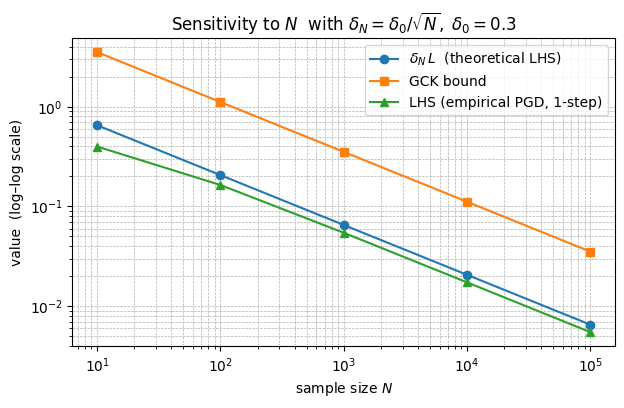

In [9]:
# ours vs GCK vs empirical LHS
# ================================================

# ------------ helper -------------
spec_norm = lambda M: np.linalg.svd(M, compute_uv=False)[0]

# ------------ hyper-parameters ----
n, n1, K   = 4, 3, 3
seeds      = range(10)
Ns         = np.logspace(1, 5, num=5, base=10, dtype=int)   # 10 … 1e5
delta0     = 0.3
t          = 1.0

rows = []

for seed in seeds:
    rng = np.random.default_rng(seed)

    # random network
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K , n1))

    # global Lipschitz L = √2 max_D ‖W2 D W1‖₂
    masks = np.array(list(itertools.product([0,1], repeat=n1)))
    L_net = math.sqrt(2)*max(spec_norm(W2 @ np.diag(m) @ W1) for m in masks)

    for N in Ns:
        delta_N = delta0 / math.sqrt(N)

        # sample data
        X = rng.standard_normal((N, n))
        Y = np.eye(K)[rng.integers(0, K, size=N)]

        grad_sq, worst_diffs = [], []
        for x, y in zip(X, Y):
            a1  = W1 @ x
            D   = np.diag(a1 > 0)
            z   = W2 @ np.maximum(a1, 0.0)
            p   = np.exp(z - z.max()); p /= p.sum()
            g   = (p - y) @ W2 @ D @ W1
            gn  = np.linalg.norm(g)
            grad_sq.append(gn**2)

            # one-step adversarial move (empirical inner sup)
            if gn > 0:
                x_adv = x + delta_N * g / gn
                z_adv = W2 @ np.maximum(W1 @ x_adv, 0.0)
                p_adv = np.exp(z_adv - z_adv.max()); p_adv /= p_adv.sum()
                diff  = -np.log((p_adv * y).sum()) + np.log((p * y).sum())
                worst_diffs.append(diff)

        grad_emp = math.sqrt(np.mean(grad_sq))
        lhs_emp  = max(worst_diffs) if worst_diffs else 0.0   # empirical LHS

        ours  = delta_N * L_net                               # exact LHS (theory)
        gck   = (delta_N*grad_emp + 0.125*delta_N**2
                 + math.sqrt(3)*n1*math.sqrt(n/N)
                 + delta_N*math.sqrt(t/(2*N)))

        rows.append(dict(seed=seed, N=N,
                         ours=ours, gck=gck, lhs_emp=lhs_emp))

# ------------ aggregate -------------
df = pd.DataFrame(rows).groupby("N").mean().reset_index()

# ------------ plot -------------------
plt.figure(figsize=(7,4))
plt.plot(df.N, df.ours,     marker="o", label=r"$\delta_N\,L$  (theoretical LHS)")
plt.plot(df.N, df.gck,      marker="s", label=r"GCK bound")
plt.plot(df.N, df.lhs_emp,  marker="^", label=r"LHS (empirical PGD, 1-step)")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"sample size $N$")
plt.ylabel("value  (log–log scale)")
plt.title(fr"Sensitivity to $N$  with $\delta_N=\delta_0/\sqrt{{N}},\;\delta_0={delta0}$")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend(); plt.show()

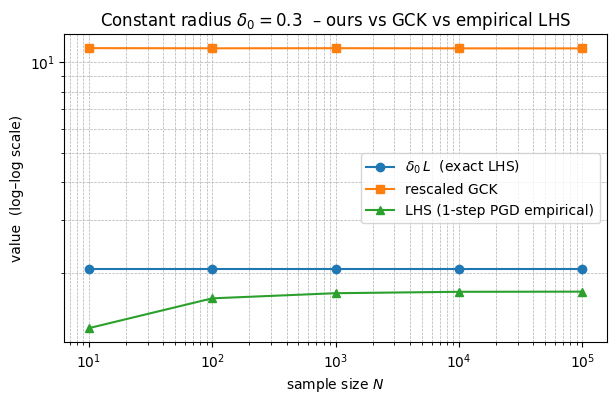

In [10]:
# =============================================================
# helper
# =============================================================
spec_norm = lambda M: np.linalg.svd(M, compute_uv=False)[0]

# =============================================================
# hyper-parameters
# =============================================================
n, n1, K   = 4, 3, 3
seeds      = range(10)                             # average over 10 nets
Ns         = np.logspace(1, 5, num=5, base=10, dtype=int)   # 1e1 … 1e5
delta0     = 0.3                                   # constant radius
t          = 1.0                                   # GCK confidence term

rows = []

for seed in seeds:
    rng = np.random.default_rng(seed)

    # -------- random 2-layer ReLU network (fixed across N) --------
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K , n1))

    # global Lipschitz  L = √2·max_D ||W2 D W1||₂  (8 masks for n1=3)
    masks  = np.array(list(itertools.product([0,1], repeat=n1)))
    L_net  = math.sqrt(2) * max(spec_norm(W2 @ np.diag(m) @ W1) for m in masks)

    for N in Ns:
        delta_N = delta0 / math.sqrt(N)            # radius in GCK theorem

        # ------------- sample data (for grad_emp & empirical LHS) -------------
        X = rng.standard_normal((N, n))
        Y = np.eye(K)[rng.integers(0, K, size=N)]

        grad_sq, diff_emp = [], []

        for x, y in zip(X, Y):
            # forward
            a1  = W1 @ x
            D   = np.diag(a1 > 0)
            z   = W2 @ np.maximum(a1, 0.0)
            p   = np.exp(z - z.max()); p /= p.sum()

            # gradient wrt x
            g   = (p - y) @ W2 @ D @ W1
            gn  = np.linalg.norm(g)
            grad_sq.append(gn**2)

            # one-step PGD adversary with radius δ0  -------
            if gn > 0:
                x_adv = x + delta0 * g / gn
                z_adv = W2 @ np.maximum(W1 @ x_adv, 0.0)
                p_adv = np.exp(z_adv - z_adv.max()); p_adv /= p_adv.sum()
                diff  = -np.log((p_adv * y).sum()) + np.log((p * y).sum())
                diff_emp.append(diff)

        grad_emp = math.sqrt(np.mean(grad_sq))
        lhs_emp  = max(diff_emp) if diff_emp else 0.0      # empirical sup

        # ---------------- bounds -----------------
        ours          = delta0 * L_net                     # theoretical LHS
        gck_original  = (delta_N*grad_emp + 0.125*delta_N**2
                         + math.sqrt(3)*n1*math.sqrt(n/N)
                         + delta_N*math.sqrt(t/(2*N)))
        gck_rescaled  = gck_original * math.sqrt(N)        # put on δ0 scale

        rows.append(dict(seed=seed, N=N,
                         ours=ours,
                         gck=gck_rescaled,
                         lhs_emp=lhs_emp))

# =============================================================
# aggregate & plot
# =============================================================
df = pd.DataFrame(rows).groupby("N").mean().reset_index()

plt.figure(figsize=(7,4))
plt.plot(df.N, df.ours,     marker="o", label=r"$\delta_0\,L$  (exact LHS)")
plt.plot(df.N, df.gck,      marker="s", label=r"rescaled GCK")
plt.plot(df.N, df.lhs_emp,  marker="^", label=r"LHS (1-step PGD empirical)")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"sample size $N$")
plt.ylabel("value  (log–log scale)")
plt.title(fr"Constant radius $\delta_0={delta0}$  – ours vs GCK vs empirical LHS")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend(); plt.show()

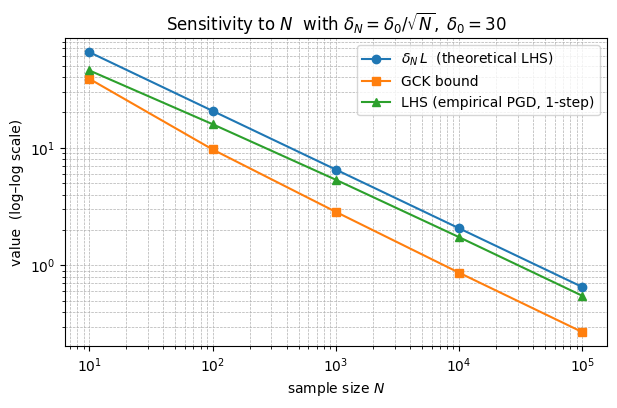

In [11]:
# ours vs GCK vs empirical LHS
# ================================================

# ------------ helper -------------
spec_norm = lambda M: np.linalg.svd(M, compute_uv=False)[0]

# ------------ hyper-parameters ----
n, n1, K   = 4, 3, 3
seeds      = range(10)
Ns         = np.logspace(1, 5, num=5, base=10, dtype=int)   # 10 … 1e5
delta0     = 30
t          = 1.0

rows = []

for seed in seeds:
    rng = np.random.default_rng(seed)

    # random network
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K , n1))

    # global Lipschitz L = √2 max_D ‖W2 D W1‖₂
    masks = np.array(list(itertools.product([0,1], repeat=n1)))
    L_net = math.sqrt(2)*max(spec_norm(W2 @ np.diag(m) @ W1) for m in masks)

    for N in Ns:
        delta_N = delta0 / math.sqrt(N)

        # sample data
        X = rng.standard_normal((N, n))
        Y = np.eye(K)[rng.integers(0, K, size=N)]

        grad_sq, worst_diffs = [], []
        for x, y in zip(X, Y):
            a1  = W1 @ x
            D   = np.diag(a1 > 0)
            z   = W2 @ np.maximum(a1, 0.0)
            p   = np.exp(z - z.max()); p /= p.sum()
            g   = (p - y) @ W2 @ D @ W1
            gn  = np.linalg.norm(g)
            grad_sq.append(gn**2)

            # one-step adversarial move (empirical inner sup)
            if gn > 0:
                x_adv = x + delta_N * g / gn
                z_adv = W2 @ np.maximum(W1 @ x_adv, 0.0)
                p_adv = np.exp(z_adv - z_adv.max()); p_adv /= p_adv.sum()
                diff  = -np.log((p_adv * y).sum()) + np.log((p * y).sum())
                worst_diffs.append(diff)

        grad_emp = math.sqrt(np.mean(grad_sq))
        lhs_emp  = max(worst_diffs) if worst_diffs else 0.0   # empirical LHS

        ours  = delta_N * L_net                               # exact LHS (theory)
        gck   = (delta_N*grad_emp + 0.125*delta_N**2
                 + math.sqrt(3)*n1*math.sqrt(n/N)
                 + delta_N*math.sqrt(t/(2*N)))

        rows.append(dict(seed=seed, N=N,
                         ours=ours, gck=gck, lhs_emp=lhs_emp))

# ------------ aggregate -------------
df = pd.DataFrame(rows).groupby("N").mean().reset_index()

# ------------ plot -------------------
plt.figure(figsize=(7,4))
plt.plot(df.N, df.ours,     marker="o", label=r"$\delta_N\,L$  (theoretical LHS)")
plt.plot(df.N, df.gck,      marker="s", label=r"GCK bound")
plt.plot(df.N, df.lhs_emp,  marker="^", label=r"LHS (empirical PGD, 1-step)")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"sample size $N$")
plt.ylabel("value  (log–log scale)")
plt.title(fr"Sensitivity to $N$  with $\delta_N=\delta_0/\sqrt{{N}},\;\delta_0={delta0}$")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend(); plt.show()


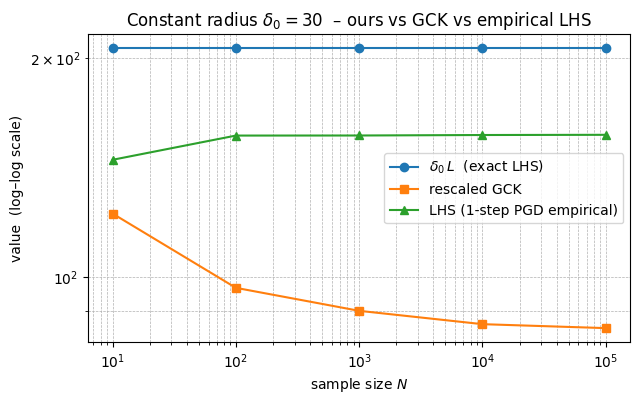

In [12]:
# =============================================================
# helper
# =============================================================
spec_norm = lambda M: np.linalg.svd(M, compute_uv=False)[0]

# =============================================================
# hyper-parameters
# =============================================================
n, n1, K   = 4, 3, 3
seeds      = range(10)                             # average over 10 nets
Ns         = np.logspace(1, 5, num=5, base=10, dtype=int)   # 1e1 … 1e5
delta0     = 30                                    # constant radius
t          = 1.0                                   # GCK confidence term

rows = []

for seed in seeds:
    rng = np.random.default_rng(seed)

    # -------- random 2-layer ReLU network (fixed across N) --------
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K , n1))

    # global Lipschitz  L = √2·max_D ||W2 D W1||₂  (8 masks for n1=3)
    masks  = np.array(list(itertools.product([0,1], repeat=n1)))
    L_net  = math.sqrt(2) * max(spec_norm(W2 @ np.diag(m) @ W1) for m in masks)

    for N in Ns:
        delta_N = delta0 / math.sqrt(N)            # radius in GCK theorem

        # ------------- sample data (for grad_emp & empirical LHS) -------------
        X = rng.standard_normal((N, n))
        Y = np.eye(K)[rng.integers(0, K, size=N)]

        grad_sq, diff_emp = [], []

        for x, y in zip(X, Y):
            # forward
            a1  = W1 @ x
            D   = np.diag(a1 > 0)
            z   = W2 @ np.maximum(a1, 0.0)
            p   = np.exp(z - z.max()); p /= p.sum()

            # gradient wrt x
            g   = (p - y) @ W2 @ D @ W1
            gn  = np.linalg.norm(g)
            grad_sq.append(gn**2)

            # one-step PGD adversary with radius δ0  -------
            if gn > 0:
                x_adv = x + delta0 * g / gn
                z_adv = W2 @ np.maximum(W1 @ x_adv, 0.0)
                p_adv = np.exp(z_adv - z_adv.max()); p_adv /= p_adv.sum()
                diff  = -np.log((p_adv * y).sum()) + np.log((p * y).sum())
                diff_emp.append(diff)

        grad_emp = math.sqrt(np.mean(grad_sq))
        lhs_emp  = max(diff_emp) if diff_emp else 0.0      # empirical sup

        # ---------------- bounds -----------------
        ours          = delta0 * L_net                     # theoretical LHS
        gck_original  = (delta_N*grad_emp + 0.125*delta_N**2
                         + math.sqrt(3)*n1*math.sqrt(n/N)
                         + delta_N*math.sqrt(t/(2*N)))
        gck_rescaled  = gck_original * math.sqrt(N)        # put on δ0 scale

        rows.append(dict(seed=seed, N=N,
                         ours=ours,
                         gck=gck_rescaled,
                         lhs_emp=lhs_emp))

# =============================================================
# aggregate & plot
# =============================================================
df = pd.DataFrame(rows).groupby("N").mean().reset_index()

plt.figure(figsize=(7,4))
plt.plot(df.N, df.ours,     marker="o", label=r"$\delta_0\,L$  (exact LHS)")
plt.plot(df.N, df.gck,      marker="s", label=r"rescaled GCK")
plt.plot(df.N, df.lhs_emp,  marker="^", label=r"LHS (1-step PGD empirical)")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"sample size $N$")
plt.ylabel("value  (log–log scale)")
plt.title(fr"Constant radius $\delta_0={delta0}$  – ours vs GCK vs empirical LHS")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend(); plt.show()

## Checking Topology

$$\mathcal D = \mathcal D _{(i)}$$

In [690]:
# ============================================================
# Numerical check that  𝓓(i) = 𝓓  for a 1-hidden-layer
# ReLU network  f(x) = W2 · ReLU(W1 x)
# ============================================================

# ------------------------  hyper-parameters  ------------------------
np.random.seed(42)   # reproducibility

n_in, n_hidden, n_out = 5, 6, 1         # <<< tweak as you wish
max_random_search    = 200_000          # tries to find 1 witness / mask
num_samples_segment  = 120              # points along each straight segment
tail_fraction        = 0.20             # last 20 %  ≡  [t₁,1]

# ------------------------  random weights  --------------------------
W1 = np.random.randn(n_hidden, n_in)
W2 = np.random.randn(n_out,   n_hidden)

# ------------------------  helper functions  ------------------------
def relu_mask(x: np.ndarray) -> np.ndarray:
    """Return diagonal mask  D(x) = diag(1_{W1 x > 0})."""
    a = (W1 @ x > 0).astype(float)
    return np.diag(a)

def mask_to_int(D: np.ndarray) -> int:
    """Convert a diagonal {0,1} mask to an integer (bitstring)."""
    return int("".join(str(int(d)) for d in np.diag(D)), 2)

# ============================================================
# 1)  Monte-Carlo search for one witness x^D per *feasible* mask
# ============================================================
witness     : dict[int, np.ndarray] = {}          # mask_int -> x^D
tries_since_new = 0

for _ in range(max_random_search):
    x = np.random.randn(n_in) * 3                 # sample in a wide ball
    key = mask_to_int(relu_mask(x))
    if key not in witness:
        witness[key] = x
        tries_since_new = 0                       # reset counter
    else:
        tries_since_new += 1

    # simple early-stop: if no new mask appeared in a while, assume done
    if tries_since_new > 20_000:
        break

D_global = set(witness.keys())                    # 𝓓  (feasible masks)

print(f"Found {len(D_global)} distinct feasible masks "
      f"out of 2^{n_hidden} = {2**n_hidden} possibilities.")

# ============================================================
# 2)  Build  𝓓(i)  by walking straight segments to every x^D
# ============================================================
x_i  = np.random.randn(n_in)                      # reference point x^(i)
D_i  = set()

for key, xD in witness.items():
    segment = ( x_i
              + np.linspace(0.0, 1.0, num_samples_segment)[:, None]
              * (xD - x_i)
              )
    tail = segment[int((1 - tail_fraction) * num_samples_segment):]  # [t₁,1]
    for z in tail:
        D_i.add(mask_to_int(relu_mask(z)))

# ============================================================
# 3)  Compare the two sets
# ============================================================
fmt = lambda k: format(k, f"0{n_hidden}b")        # human-readable bitstring

print("\n𝓓     (feasible masks):")
print("  {" + ", ".join(sorted(fmt(k) for k in D_global)) + "}")

print("\n𝓓(i)  (segment-tail masks from x^(i)):")
print("  {" + ", ".join(sorted(fmt(k) for k in D_i)) + "}")

print("\nSets equal?", D_global == D_i)

Found 61 distinct feasible masks out of 2^6 = 64 possibilities.

𝓓     (feasible masks):
  {000000, 000001, 000010, 000011, 000100, 000101, 000111, 001000, 001001, 001010, 001011, 001100, 001101, 001110, 001111, 010000, 010001, 010010, 010011, 010100, 010101, 010111, 011000, 011001, 011010, 011011, 011100, 011101, 011110, 011111, 100000, 100001, 100010, 100011, 100100, 100101, 100110, 100111, 101000, 101010, 101011, 101100, 101101, 101110, 101111, 110000, 110001, 110010, 110011, 110100, 110101, 110110, 110111, 111000, 111001, 111010, 111011, 111100, 111101, 111110, 111111}

𝓓(i)  (segment-tail masks from x^(i)):
  {000000, 000001, 000010, 000011, 000100, 000101, 000111, 001000, 001001, 001010, 001011, 001100, 001101, 001110, 001111, 010000, 010001, 010010, 010011, 010100, 010101, 010111, 011000, 011001, 011010, 011011, 011100, 011101, 011110, 011111, 100000, 100001, 100010, 100011, 100100, 100101, 100110, 100111, 101000, 101010, 101011, 101100, 101101, 101110, 101111, 110000, 110001, 1

$$
J^*u = w
$$

In [691]:
# ------------------------------------------------------------------
# 0.  Build W1, W2, D*  **with   rank(J*) = 2** guaranteed
# ------------------------------------------------------------------
seed = 42
rng  = np.random.default_rng(seed)

def random_fullrank_2x2(rng):
    while True:
        W = rng.standard_normal((2, 2))
        if abs(np.linalg.det(W)) > 1e-3:
            return W

while True:
    W1 = random_fullrank_2x2(rng)
    W2 = rng.standard_normal((2, 2))

    # choose D* exactly as before
    best_val, D_star = -np.inf, None
    for bits in range(4):
        D = np.diag([(bits >> k) & 1 for k in range(2)])
        val = np.linalg.svd(W2 @ D @ W1, compute_uv=False)[0]
        if val > best_val:
            best_val, D_star = val, D
    J_star = W2 @ D_star @ W1

    # accept only if J_star is full row rank (==2)
    if np.linalg.matrix_rank(J_star) == 2:
        break

# ------------------------------------------------------------
# 2.  Optimal mask D*  (exhaustive over 2^2 = 4 masks)
# ------------------------------------------------------------
def spectral_norm(A): return np.linalg.svd(A, compute_uv=False)[0]

best_val, D_star = -np.inf, None
for bits in range(4):
    D = np.diag([(bits >> k) & 1 for k in range(2)])
    val = spectral_norm(W2 @ D @ W1)
    if val > best_val:
        best_val, D_star = val, D

J_star = W2 @ D_star @ W1
radius = spectral_norm(J_star)

# ------------------------------------------------------------
# 3.  Strict ReLU cell 𝒞*  – dense grid sampling
# ------------------------------------------------------------
grid = np.linspace(-8, 8, 1000)          # wider window
xx, yy = np.meshgrid(grid, grid)
XY = np.c_[xx.ravel(), yy.ravel()]       # shape (M, 2)

mask = np.ones(XY.shape[0], dtype=bool)
for k in range(2):
    vals = XY @ W1[k]                    # a_k·x + b_k·y
    if D_star[k, k] == 1:                # neuron kept ⇒ strict “> 0”
        mask &= vals > 0
    else:                                # neuron killed ⇒ strict “< 0”
        mask &= vals < 0

C_pts = XY[mask]                         # points in 𝒞*

# ------------------------------------------------------------
# 4.  Image cone V = J*Ω  and vector w
# ------------------------------------------------------------
V_pts = (J_star @ C_pts.T).T

c, j_plus = 0, 1
e = np.eye(2)
w = (radius / np.sqrt(2)) * (e[j_plus] - e[c])   # proof vector

# ============================================================
# Nicely formatted symbolic print-out of all sets
# (assumes W1, W2, D_star, J_star, w, radius are defined)
# ============================================================
np.set_printoptions(precision=4, suppress=True)

def banner(t):
    print(f"\n=== {t} ===")

def mat(name, M):
    print(f"{name} =\n{M}\n")

# 0) Matrices & basic numbers --------------------------------
banner("NETWORK INGREDIENTS")
mat("W1", W1)
mat("W2", W2)
print("D* (bitstring) =", "".join(str(int(x)) for x in np.diag(D_star)))
mat("D*", D_star)
mat("J*", J_star)
print(f"‖J*‖₂ = {radius:.4f}")

# 1) Strict ReLU cell 𝒞* -------------------------------------
banner("STRICT ReLU CELL 𝒞*")
rows = []
for k in range(W1.shape[0]):
    coef = "D*W1" if D_star[k, k] == 1 else "(I−D*)W1"
    sign = ">" if D_star[k, k] == 1 else "<"
    a, b = (W1[k] if D_star[k, k] == 1 else W1[k]).round(4)
    rows.append(f"{coef}[{k}] · x  {sign}  0   "
                f"(⇒ {a:+.4f}·x₁ {b:+.4f}·x₂ {sign} 0)")
print("𝒞* = { x ∈ ℝ² :")
for r in rows:
    print("       " + r)
print("     }")

# 2) Recession cone & interior Ω -----------------------------
banner("RECESSION CONE rec(𝒞*)")
rows_rec = []
for k in range(W1.shape[0]):
    coef = "D*W1" if D_star[k, k] == 1 else "(I−D*)W1"
    cmp = "≥" if D_star[k, k] == 1 else "≤"
    a, b = (W1[k] if D_star[k, k] == 1 else W1[k]).round(4)
    rows_rec.append(f"{coef}[{k}] · u  {cmp}  0   "
                    f"(⇒ {a:+.4f}·u₁ {b:+.4f}·u₂ {cmp} 0)")
print("rec(𝒞*) = { u ≠ 0 :")
for r in rows_rec:
    print("             " + r)
print("           }")
print("\nΩ = int(rec(𝒞*))  (all inequalities strict)")

# 3) Image cone V and spherical slice V* ---------------------
banner("IMAGE CONE V  AND  SLICE V*")
print("V   = J* Ω   (linear image of the interior cone)")
print(f"Sphere radius = ‖J*‖₂ = {radius:.4f}")
print("V*  = V ∩ { z : ‖z‖₂ = ‖J*‖₂ }  (open arc on that circle)")

# 4) Proof vector w ------------------------------------------
banner("PROOF VECTOR w")
print("w =", w.round(4))
print(f"‖w‖₂ = {np.linalg.norm(w):.4f} (matches ‖J*‖₂)")


=== NETWORK INGREDIENTS ===
W1 =
[[-0.0168 -0.853 ]
 [ 0.8794  0.7778]]

W2 =
[[ 0.066   1.1272]
 [ 0.4675 -0.8593]]

D* (bitstring) = 11
D* =
[[1 0]
 [0 1]]

J* =
[[ 0.9902  0.8204]
 [-0.7635 -1.0672]]

‖J*‖₂ = 1.8220

=== STRICT ReLU CELL 𝒞* ===
𝒞* = { x ∈ ℝ² :
       D*W1[0] · x  >  0   (⇒ -0.0168·x₁ -0.8530·x₂ > 0)
       D*W1[1] · x  >  0   (⇒ +0.8794·x₁ +0.7778·x₂ > 0)
     }

=== RECESSION CONE rec(𝒞*) ===
rec(𝒞*) = { u ≠ 0 :
             D*W1[0] · u  ≥  0   (⇒ -0.0168·u₁ -0.8530·u₂ ≥ 0)
             D*W1[1] · u  ≥  0   (⇒ +0.8794·u₁ +0.7778·u₂ ≥ 0)
           }

Ω = int(rec(𝒞*))  (all inequalities strict)

=== IMAGE CONE V  AND  SLICE V* ===
V   = J* Ω   (linear image of the interior cone)
Sphere radius = ‖J*‖₂ = 1.8220
V*  = V ∩ { z : ‖z‖₂ = ‖J*‖₂ }  (open arc on that circle)

=== PROOF VECTOR w ===
w = [-1.2883  1.2883]
‖w‖₂ = 1.8220 (matches ‖J*‖₂)


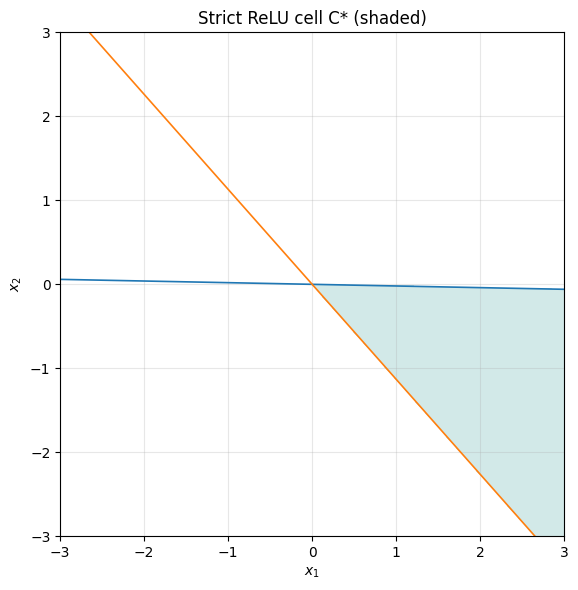

In [692]:
# ------------------------------------------------------------
# 5.  Plot the strict ReLU cell 𝒞* – now with shading
# ------------------------------------------------------------

# --- Build a Boolean mask for the two strict inequalities ----
cond = np.ones_like(xx, dtype=bool)      # start with “all True”
for k in range(2):
    lin = W1[k, 0] * xx + W1[k, 1] * yy  # a·x + b·y
    if D_star[k, k] == 1:                # neuron kept  (>) 
        cond &= (lin > 0)
    else:                                # neuron killed (<)
        cond &= (lin < 0)

# --- Plot ----------------------------------------------------
plt.figure(figsize=(6, 6))

# 1) shade the admissible region (alpha keeps grid visible)
plt.contourf(xx, yy, cond.astype(int), levels=[0.5, 1.5], alpha=0.20)

# 2) overlay the two decision boundaries
x_line = np.linspace(-4, 4, 900)
for k in range(2):
    a, b = W1[k]
    if abs(b) > 1e-12:                               # non-vertical
        y_line = (-a / b) * x_line
        style  = '-' if D_star[k, k] == 1 else '--'  # solid vs dashed
        plt.plot(x_line, y_line, style, linewidth=1.2)
    else:                                            # vertical boundary
        plt.axvline(0, linestyle=style, linewidth=1.2)

# 3) cosmetics
plt.xlim([-3, 3]); plt.ylim([-3, 3])
plt.xlabel(r'$x_1$'); plt.ylabel(r'$x_2$')
plt.title('Strict ReLU cell C* (shaded)')
plt.grid(alpha=0.3)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

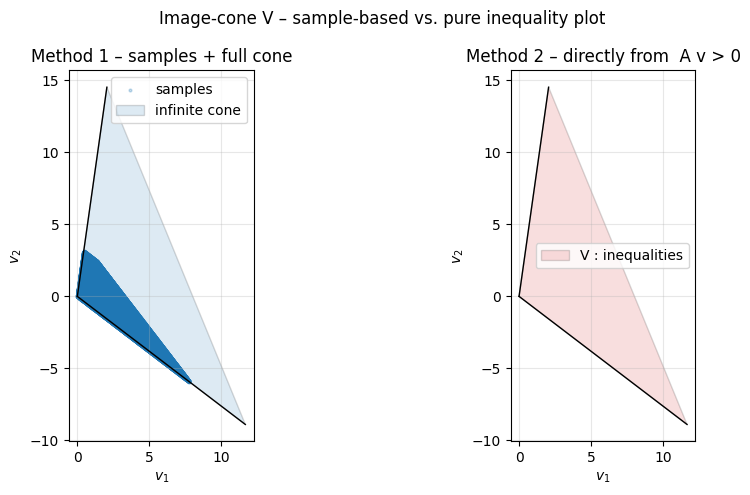

In [693]:
# ==============================================================
# Visualising V with    • left: sample cloud + infinite cone
#                       • right: pure inequality-based cone
# ==============================================================
# -----------------------------------------------------------------
# 1.  Helper – convex hull (tiny implementation, SciPy optional)
# -----------------------------------------------------------------
def convex_hull(pts: np.ndarray) -> np.ndarray:
    """Return vertices of the 2-D convex hull in CCW order."""
    try:
        from scipy.spatial import ConvexHull
        hull = ConvexHull(pts)
        return pts[hull.vertices]
    except Exception:                                   # fallback Graham scan
        pts = pts[np.argsort(np.arctan2(pts[:, 1], pts[:, 0]))]
        def cross(o, a, b):
            return (a[0]-o[0])*(b[1]-o[1]) - (a[1]-o[1])*(b[0]-o[0])
        L = []
        for p in np.concatenate([pts, pts[::-1]]):
            while len(L) >= 2 and cross(L[-2], L[-1], p) <= 0:
                L.pop()
            L.append(p)
        return np.asarray(L)


# -----------------------------------------------------------------
# 2.  LEFT PLOT  – sample cloud + extended cone hull
# -----------------------------------------------------------------
def plot_samples_plus_infinite_cone(ax, V_pts, factor=1.5,
                                    cloud_c="#1f77b4", cone_c="#1f77b4"):
    """
    ax      : matplotlib Axes to draw on
    V_pts   : (M,2) array of sample points
    factor  : how far to extend each boundary ray beyond max ‖v‖
    """
    # 2-a scatter the raw projected points
    ax.scatter(V_pts[:, 0], V_pts[:, 1], s=4, alpha=0.25,
               color=cloud_c, label="samples")

    # 2-b find the two extreme boundary rays (min/max polar angle)
    hull   = convex_hull(np.vstack([V_pts, np.zeros((1, 2))]))
    hull   = hull[np.any(hull, axis=1)]        # drop the origin
    angles = np.arctan2(hull[:, 1], hull[:, 0])
    d1 = hull[ np.argmin(angles) ];  dir1 = d1 / np.linalg.norm(d1)
    d2 = hull[ np.argmax(angles) ];  dir2 = d2 / np.linalg.norm(d2)

    max_len = np.linalg.norm(V_pts, axis=1).max() * factor

    # polygon = origin + two long boundary rays
    cone_poly = np.vstack([[0, 0], dir1*max_len, dir2*max_len])
    ax.add_patch(
        Polygon(cone_poly, closed=True, facecolor=cone_c,
                edgecolor="k", alpha=0.15, label="infinite cone")
    )
    ax.plot([0, dir1[0]*max_len], [0, dir1[1]*max_len], color="k", lw=1)
    ax.plot([0, dir2[0]*max_len], [0, dir2[1]*max_len], color="k", lw=1)

    ax.set_title("Method 1 – samples + full cone")
    ax.set_aspect("equal")
    ax.legend()


# -----------------------------------------------------------------
# 3.  RIGHT PLOT  – direct inequality description
# -----------------------------------------------------------------
def compute_halfspace_matrix(W1, D_star, J_star):
    """
    Return A (2×2) s.t.    A v > 0   describes V in v-space.
    Each row i already has the sign flipped so that '>' is the test.
    """
    A = []
    Jinv = np.linalg.inv(J_star)
    for k in range(2):
        row = W1[k] @ Jinv
        s   = +1 if D_star[k, k] == 1 else -1       # flip for "<" rows
        A.append(s * row)
    return np.vstack(A)              # shape (2,2)


def boundary_dirs_from_A(A):
    """
    Given two half-spaces A v > 0 with A (2×2 full rank), return the
    two unit vectors that lie on the boundaries and point into the region.
    """
    dirs = []
    for i in range(2):
        n = A[i]
        d = np.array([-n[1], n[0]])        # rotate left 90°
        if (A @ d > 0).all():
            dirs.append(d / np.linalg.norm(d))
        else:                              # rotate right 90°
            d = -d
            dirs.append(d / np.linalg.norm(d))
    # order CCW
    angles = np.arctan2([d[1] for d in dirs], [d[0] for d in dirs])
    return np.array(dirs)[np.argsort(angles)]


def plot_inequality_cone(ax, W1, D_star, J_star,
                         max_len=None, color="#d62728"):
    """
    ax       : matplotlib Axes
    max_len  : ray length (defaults to left-panel max_norm for parity)
    """
    A = compute_halfspace_matrix(W1, D_star, J_star)
    d1, d2 = boundary_dirs_from_A(A)

    if max_len is None:
        raise ValueError("Supply max_len so both panels share the same scale")

    # draw filled wedge
    poly = np.vstack([[0, 0], d1*max_len, d2*max_len])
    ax.add_patch(
        Polygon(poly, closed=True, facecolor=color,
                edgecolor="k", alpha=0.15, label="V : inequalities")
    )
    ax.plot([0, d1[0]*max_len], [0, d1[1]*max_len], color="k", lw=1)
    ax.plot([0, d2[0]*max_len], [0, d2[1]*max_len], color="k", lw=1)

    ax.set_title("Method 2 – directly from  A v > 0")
    ax.set_aspect("equal")
    ax.legend()


# -----------------------------------------------------------------
# 4.  Convenience wrapper
# -----------------------------------------------------------------
def show_cone_comparison():
    fig, (axL, axR) = plt.subplots(1, 2, figsize=(10, 5))

    # left panel
    plot_samples_plus_infinite_cone(axL, V_pts, factor=1.5)

    # right panel – use the SAME max_len so scales match
    max_len = np.linalg.norm(V_pts, axis=1).max() * 1.5
    plot_inequality_cone(axR, W1, D_star, J_star, max_len=max_len)

    for ax in (axL, axR):
        ax.set_xlabel("$v_1$")
        ax.set_ylabel("$v_2$")
        ax.grid(alpha=0.3)

    fig.suptitle("Image-cone V – sample-based vs. pure inequality plot")
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------------
# Example call (after your network-building cell ran):
show_cone_comparison()

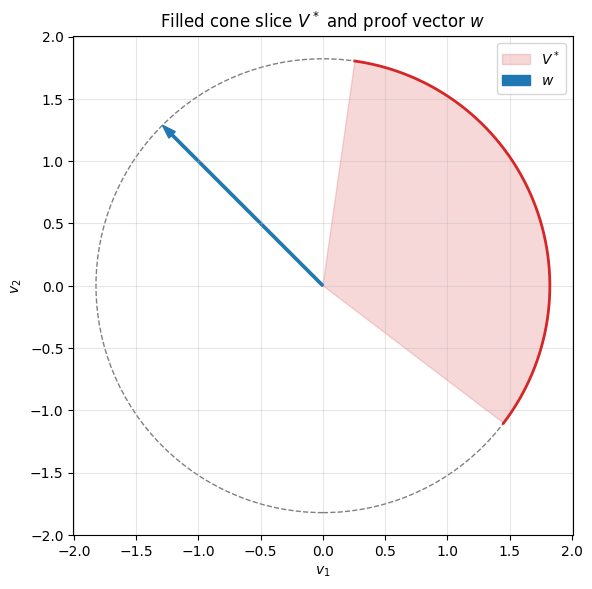

In [694]:
# ==========================================================================
#  Plot the filled cone slice V* together with the proof vector w
#  Assumes: W1, D_star, J_star, radius, w are already defined.
# ==========================================================================
# ------------------------------------------------------------
# 1.  Half-space matrix  A  so that  V = { v : A v > 0 }
# ------------------------------------------------------------
Jinv = np.linalg.inv(J_star)
A = np.vstack([
    (+1 if D_star[k, k] == 1 else -1) * (W1[k] @ Jinv)   # flip "<" rows
    for k in range(2)
])

# ------------------------------------------------------------
# 2.  Sample the circle and keep the longest contiguous arc
# ------------------------------------------------------------
num   = 2000
theta = np.linspace(0, 2*np.pi, num, endpoint=False)
circle_pts = np.c_[np.cos(theta), np.sin(theta)] * radius
mask  = (A @ circle_pts.T > 0).all(axis=0)

idx_true = np.where(mask)[0]
splits   = np.where(np.diff(idx_true) != 1)[0] + 1
segments = np.split(idx_true, splits)
if segments[0][0] == 0 and segments[-1][-1] == num - 1:
    segments[0] = np.concatenate([segments[-1], segments[0]])
    segments.pop()
arc_idx = max(segments, key=len)                  # longest valid segment
arc_pts = circle_pts[arc_idx]

# ------------------------------------------------------------
# 3.  Plot
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))

# dashed reference circle
ax.add_patch(plt.Circle((0, 0), radius,
                        edgecolor="gray", linestyle="--", facecolor="none"))

# filled cone slice (origin + arc)
cone_poly = np.vstack([[0, 0], arc_pts])
ax.add_patch(
    Polygon(cone_poly, closed=True, facecolor="#d62728", alpha=0.18,
            edgecolor="#d62728", label=r"$V^*$")
)

# outline of the arc (optional but makes the boundary crisp)
ax.plot(arc_pts[:, 0], arc_pts[:, 1], color="#d62728", lw=2)

# proof vector w (scaled arrow)
ax.arrow(0, 0, w[0], w[1],
         width=0.01 * radius,
         head_width=0.04 * radius,
         head_length=0.06 * radius,
         length_includes_head=True,
         color="#1f77b4", label=r"$w$")

# cosmetics
ax.set_aspect("equal")
ax.set_xlabel("$v_1$")
ax.set_ylabel("$v_2$")
ax.set_title(r"Filled cone slice $V^*$ and proof vector $w$")
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

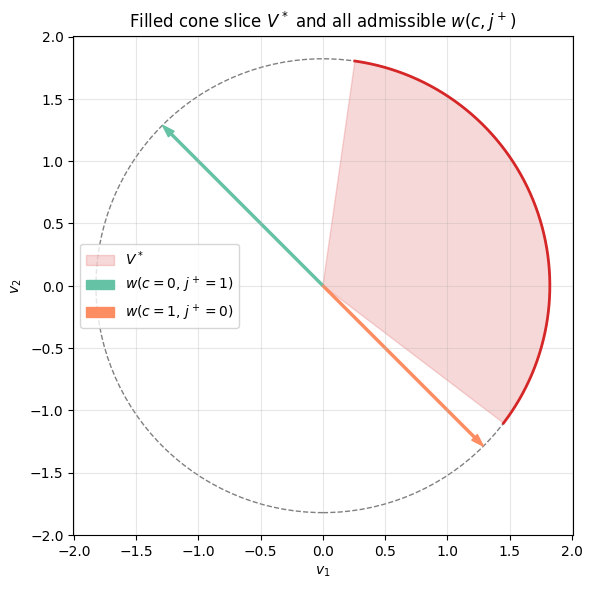

In [695]:
# =========================================================================
# Show the filled cone slice V* and *all* possible proof vectors w(c,j+)
# =========================================================================
# -------------------------------------------------------------------------
# 0.  Assume W1, D_star, J_star, radius   are already defined.
# -------------------------------------------------------------------------
n = J_star.shape[0]        # should be 2 here
e = np.eye(n)

# -------------------------------------------------------------------------
# 1.  Half-space matrix  A  so that   V = { v : A v > 0 }
# -------------------------------------------------------------------------
Jinv = np.linalg.inv(J_star)
A = np.vstack([
    (+1 if D_star[k, k] == 1 else -1) * (W1[k] @ Jinv)
    for k in range(n)
])

# -------------------------------------------------------------------------
# 2.  Find the longest contiguous arc on the circle that satisfies A·v>0
# -------------------------------------------------------------------------
num         = 2000
theta       = np.linspace(0, 2*np.pi, num, endpoint=False)
circle_pts  = np.c_[np.cos(theta), np.sin(theta)] * radius
mask        = (A @ circle_pts.T > 0).all(axis=0)

idx_true = np.where(mask)[0]
splits    = np.where(np.diff(idx_true) != 1)[0] + 1
segments  = np.split(idx_true, splits)
if segments[0][0] == 0 and segments[-1][-1] == num - 1:
    segments[0] = np.concatenate([segments[-1], segments[0]])
    segments.pop()
arc_idx  = max(segments, key=len)
arc_pts  = circle_pts[arc_idx]

# -------------------------------------------------------------------------
# 3.  Gather *all* w(c,j+)  (c ≠ j+)
# -------------------------------------------------------------------------
w_list = []
for c in range(n):
    for j_plus in range(n):
        if j_plus == c:
            continue
        w_vec = (radius / np.sqrt(2)) * (e[j_plus] - e[c])
        w_list.append((c, j_plus, w_vec))

# -------------------------------------------------------------------------
# 4.  Plot
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))

# -- filled cone slice
cone_poly = np.vstack([[0, 0], arc_pts])
ax.add_patch(
    Polygon(cone_poly, closed=True,
            facecolor="#d62728", alpha=0.18,
            edgecolor="#d62728", label=r"$V^*$")
)
ax.plot(arc_pts[:, 0], arc_pts[:, 1], color="#d62728", lw=2)

# -- reference circle
ax.add_patch(plt.Circle((0, 0), radius,
                        edgecolor="gray", linestyle="--",
                        facecolor="none"))

# -- all w-vectors
colors = plt.cm.Set2.colors             # a palette of distinct colours
arrow_kw = dict(width=0.009*radius,
                head_width=0.035*radius,
                head_length=0.055*radius,
                length_includes_head=True)

for k, (c, j_plus, w_vec) in enumerate(w_list):
    label = fr"$w(c={c},\,j^+={j_plus})$"
    ax.arrow(0, 0, w_vec[0], w_vec[1],
             color=colors[k % len(colors)], label=label, **arrow_kw)

# -- cosmetics
ax.set_aspect("equal")
ax.set_xlabel("$v_1$")
ax.set_ylabel("$v_2$")
ax.set_title(r"Filled cone slice $V^*$ and all admissible $w(c,j^+)$")
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()


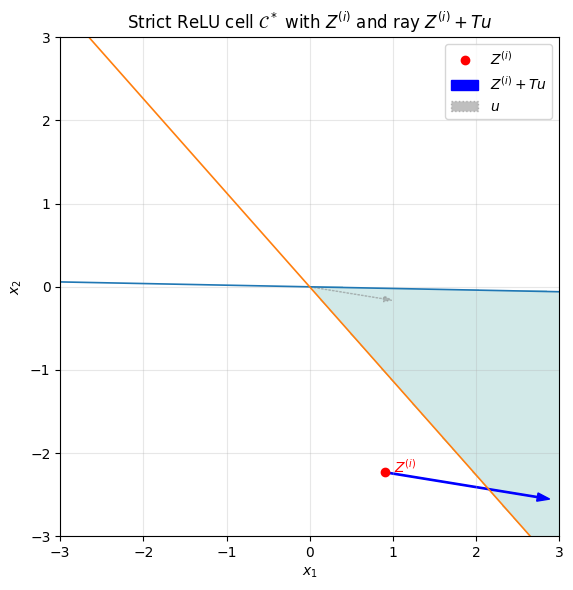

In [696]:
# ------------------------------------------------------------
# Reproducible plot of ReLU cell, Z^{(i)}, direction u, and ray Z^{(i)} + Tu
# ------------------------------------------------------------
# === reproducible RNG ===
seed = 123
rng = np.random.default_rng(seed)

# 1) Reproducible test point anywhere in ℝ²
Z_i = rng.uniform(low=-2.5, high=2.5, size=2)

# 2) Reproducible direction u ∈ int(Ω)
u_raw = C_pts[rng.integers(len(C_pts))]    # C_pts must already be defined
u = u_raw / np.linalg.norm(u_raw)

# 3) Target ray end: Z^{(i)} + T_max u
T_max = 2
ray_end = Z_i + T_max * u

# 4) Boolean mask for the strict ReLU cell 𝒞*
cond = np.ones_like(xx, dtype=bool)
for k in range(2):
    lin = W1[k, 0] * xx + W1[k, 1] * yy
    if D_star[k, k] == 1:
        cond &= (lin > 0)
    else:
        cond &= (lin < 0)

# --- Plot ---
plt.figure(figsize=(6, 6))

# 1) Shade the strict ReLU cell
plt.contourf(xx, yy, cond.astype(int), levels=[0.5, 1.5], alpha=0.20)

# 2) Plot decision boundaries
x_line = np.linspace(-4, 4, 900)
for k in range(2):
    a, b = W1[k]
    style = '-' if D_star[k, k] == 1 else '--'
    if abs(b) > 1e-12:
        y_line = (-a / b) * x_line
        plt.plot(x_line, y_line, style, linewidth=1.2)
    else:
        plt.axvline(0, linestyle=style, linewidth=1.2)

# 3) Plot Z^{(i)} as red dot
plt.plot(Z_i[0], Z_i[1], 'ro', label=r"$Z^{(i)}$")
plt.text(Z_i[0] + 0.1, Z_i[1], r"$Z^{(i)}$", color='red')

# 4) Ray Z^{(i)} + T·u as blue arrow
plt.arrow(Z_i[0], Z_i[1],
          (ray_end - Z_i)[0], (ray_end - Z_i)[1],
          color='blue', width=0.015,
          head_width=0.1, head_length=0.15,
          length_includes_head=True,
          label=r"$Z^{(i)} + T u$")

# 5) Optional: gray dashed arrow showing u from origin
plt.arrow(0, 0, u[0], u[1],
          color='gray', alpha=0.5, linestyle=':',
          head_width=0.07, head_length=0.1,
          length_includes_head=True,
          label=r"$u$")

# --- Final formatting ---
plt.xlim([-3, 3]); plt.ylim([-3, 3])
plt.xlabel(r'$x_1$'); plt.ylabel(r'$x_2$')
plt.title(r'Strict ReLU cell $\mathcal{C}^*$ with $Z^{(i)}$ and ray $Z^{(i)} + Tu$')
plt.grid(alpha=0.3)
plt.gca().set_aspect('equal')
plt.legend()
plt.tight_layout()
plt.show()

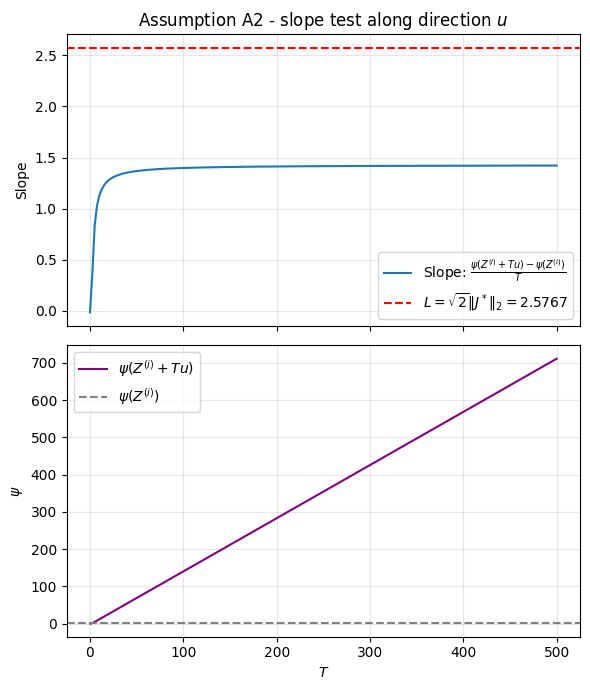

In [697]:
# ================================================================
# Assumption A2 test: slope and ψ values along the ray Z^{(i)} + T u
# ================================================================
true_class = np.argmax(W2 @ np.maximum(W1 @ Z_i, 0.))

def psi_beta(z):
    z_proj = W2 @ np.maximum(W1 @ z, 0.)
    p = np.exp(z_proj - np.max(z_proj))
    p = p / p.sum()
    return -np.log(p[true_class]) 

# --- compute ψ(Z^{(i)}) ---
psi_Z_i = psi_beta(Z_i)

# --- scan over T ---
T_vals = np.linspace(1e-3, 500, num=200)     # avoid divide-by-zero at T = 0
psi_vals = []
slopes = []

for T in T_vals:
    Z_eps = Z_i + T * u
    psi_T = psi_beta(Z_eps)
    psi_vals.append(psi_T)
    slopes.append((psi_T - psi_Z_i) / T)

# --- constant L = √2 · ‖J*‖₂
L = np.sqrt(2) * radius

# --- plot slope vs T ---
fig, axs = plt.subplots(2, 1, figsize=(6, 7), sharex=True)

axs[0].plot(T_vals, slopes, label=r"Slope: $\frac{\psi(Z^{(i)} + Tu) - \psi(Z^{(i)})}{T}$")
axs[0].axhline(y=L, color='red', linestyle='--', label=fr"$L = \sqrt{{2}} \|J^*\|_2 = {L:.4f}$")
axs[0].set_ylabel("Slope")
axs[0].set_title("Assumption A2 - slope test along direction $u$")
axs[0].legend()
axs[0].grid(alpha=0.3)

# --- plot ψ(Z_perturbed) vs T ---
axs[1].plot(T_vals, psi_vals, color='purple', label=r"$\psi(Z^{(i)} + T u)$")
axs[1].axhline(y=psi_Z_i, color='gray', linestyle='--', label=r"$\psi(Z^{(i)})$")
axs[1].set_xlabel("$T$")
axs[1].set_ylabel(r"$\psi$")
axs[1].legend()
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


=== NETWORK INGREDIENTS ===
W1 =
[[-0.9775  0.0692]
 [-0.0404 -0.3053]]

W2 =
[[-0.5414 -0.6144]
 [ 0.4635  1.1171]]

D* (bitstring) = 11
D* =
[[1 0]
 [0 1]]

J* =
[[ 0.554   0.1501]
 [-0.4982 -0.309 ]]

‖J*‖₂ = 0.8118

=== STRICT ReLU CELL 𝒞* ===
𝒞* = { x ∈ ℝ² :
       D*W1[0] · x  >  0   (⇒ -0.9775·x₁ +0.0692·x₂ > 0)
       D*W1[1] · x  >  0   (⇒ -0.0404·x₁ -0.3053·x₂ > 0)
     }

=== RECESSION CONE rec(𝒞*) ===
rec(𝒞*) = { u ≠ 0 :
             D*W1[0] · u  ≥  0   (⇒ -0.9775·u₁ +0.0692·u₂ ≥ 0)
             D*W1[1] · u  ≥  0   (⇒ -0.0404·u₁ -0.3053·u₂ ≥ 0)
           }

Ω = int(rec(𝒞*))  (all inequalities strict)

=== IMAGE CONE V  AND  SLICE V* ===
V   = J* Ω   (linear image of the interior cone)
Sphere radius = ‖J*‖₂ = 0.8118
V*  = V ∩ { z : ‖z‖₂ = ‖J*‖₂ }  (open arc on that circle)

=== PROOF VECTOR w ===
w = [-0.5741  0.5741]
‖w‖₂ = 0.8118 (matches ‖J*‖₂)


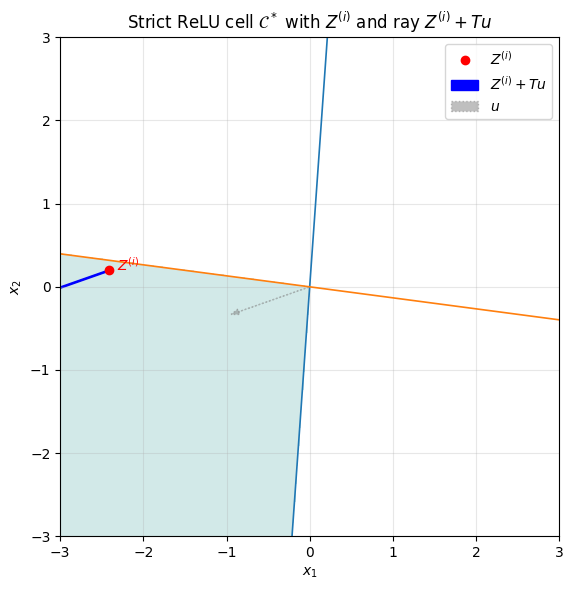

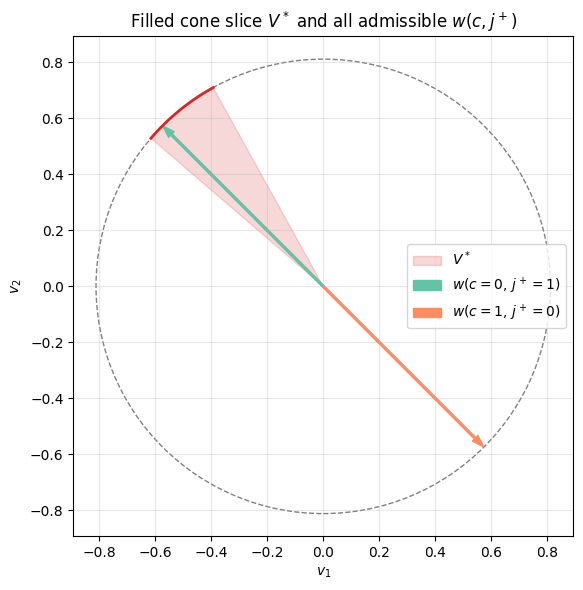

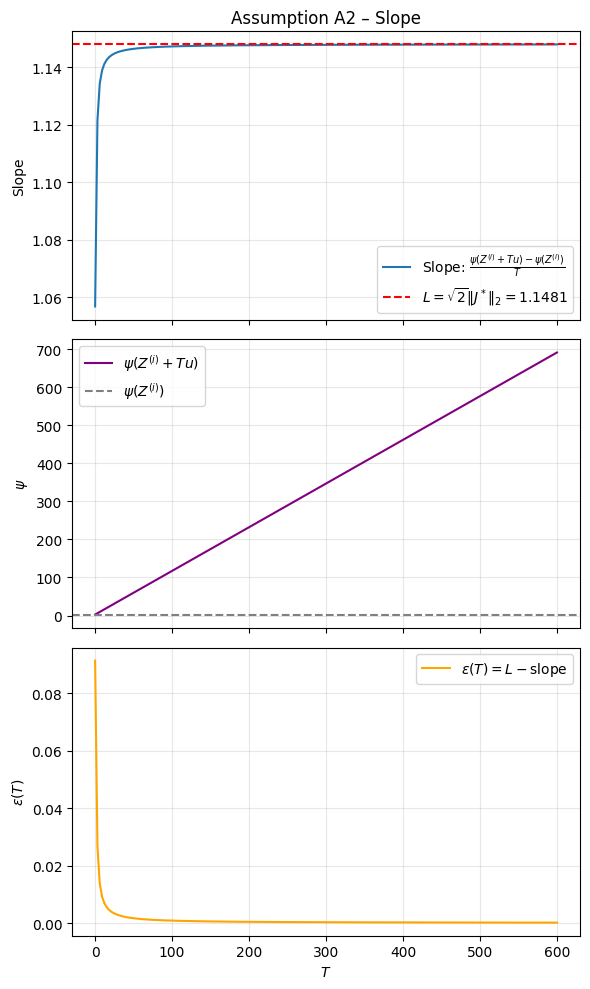

In [702]:
# 162840------------------------------------------------------------------
# 0.  Build W1, W2, D*  **with   rank(J*) = 2** guaranteed
# ------------------------------------------------------------------
seed = 162840
rng  = np.random.default_rng(seed)

def random_fullrank_2x2(rng):
    while True:
        W = rng.standard_normal((2, 2))
        if abs(np.linalg.det(W)) > 1e-3:
            return W

while True:
    W1 = random_fullrank_2x2(rng)
    W2 = rng.standard_normal((2, 2))

    # choose D* exactly as before
    best_val, D_star = -np.inf, None
    for bits in range(4):
        D = np.diag([(bits >> k) & 1 for k in range(2)])
        val = np.linalg.svd(W2 @ D @ W1, compute_uv=False)[0]
        if val > best_val:
            best_val, D_star = val, D
    J_star = W2 @ D_star @ W1

    # accept only if J_star is full row rank (==2)
    if np.linalg.matrix_rank(J_star) == 2:
        break

# ------------------------------------------------------------
# 2.  Optimal mask D*  (exhaustive over 2^2 = 4 masks)
# ------------------------------------------------------------
def spectral_norm(A): return np.linalg.svd(A, compute_uv=False)[0]

best_val, D_star = -np.inf, None
for bits in range(4):
    D = np.diag([(bits >> k) & 1 for k in range(2)])
    val = spectral_norm(W2 @ D @ W1)
    if val > best_val:
        best_val, D_star = val, D

J_star = W2 @ D_star @ W1
radius = spectral_norm(J_star)

# ------------------------------------------------------------
# 3.  Strict ReLU cell 𝒞*  – dense grid sampling
# ------------------------------------------------------------
grid = np.linspace(-8, 8, 1000)          # wider window
xx, yy = np.meshgrid(grid, grid)
XY = np.c_[xx.ravel(), yy.ravel()]       # shape (M, 2)

mask = np.ones(XY.shape[0], dtype=bool)
for k in range(2):
    vals = XY @ W1[k]                    # a_k·x + b_k·y
    if D_star[k, k] == 1:                # neuron kept ⇒ strict “> 0”
        mask &= vals > 0
    else:                                # neuron killed ⇒ strict “< 0”
        mask &= vals < 0

C_pts = XY[mask]                         # points in 𝒞*

# ------------------------------------------------------------
# 4.  Image cone V = J*Ω  and vector w
# ------------------------------------------------------------
V_pts = (J_star @ C_pts.T).T

c, j_plus = 0, 1
e = np.eye(2)
w = (radius / np.sqrt(2)) * (e[j_plus] - e[c])   # proof vector

# ============================================================
# Nicely formatted symbolic print-out of all sets
# (assumes W1, W2, D_star, J_star, w, radius are defined)
# ============================================================
np.set_printoptions(precision=4, suppress=True)

def banner(t):
    print(f"\n=== {t} ===")

def mat(name, M):
    print(f"{name} =\n{M}\n")

# 0) Matrices & basic numbers --------------------------------
banner("NETWORK INGREDIENTS")
mat("W1", W1)
mat("W2", W2)
print("D* (bitstring) =", "".join(str(int(x)) for x in np.diag(D_star)))
mat("D*", D_star)
mat("J*", J_star)
print(f"‖J*‖₂ = {radius:.4f}")

# 1) Strict ReLU cell 𝒞* -------------------------------------
banner("STRICT ReLU CELL 𝒞*")
rows = []
for k in range(W1.shape[0]):
    coef = "D*W1" if D_star[k, k] == 1 else "(I−D*)W1"
    sign = ">" if D_star[k, k] == 1 else "<"
    a, b = (W1[k] if D_star[k, k] == 1 else W1[k]).round(4)
    rows.append(f"{coef}[{k}] · x  {sign}  0   "
                f"(⇒ {a:+.4f}·x₁ {b:+.4f}·x₂ {sign} 0)")
print("𝒞* = { x ∈ ℝ² :")
for r in rows:
    print("       " + r)
print("     }")

# 2) Recession cone & interior Ω -----------------------------
banner("RECESSION CONE rec(𝒞*)")
rows_rec = []
for k in range(W1.shape[0]):
    coef = "D*W1" if D_star[k, k] == 1 else "(I−D*)W1"
    cmp = "≥" if D_star[k, k] == 1 else "≤"
    a, b = (W1[k] if D_star[k, k] == 1 else W1[k]).round(4)
    rows_rec.append(f"{coef}[{k}] · u  {cmp}  0   "
                    f"(⇒ {a:+.4f}·u₁ {b:+.4f}·u₂ {cmp} 0)")
print("rec(𝒞*) = { u ≠ 0 :")
for r in rows_rec:
    print("             " + r)
print("           }")
print("\nΩ = int(rec(𝒞*))  (all inequalities strict)")

# 3) Image cone V and spherical slice V* ---------------------
banner("IMAGE CONE V  AND  SLICE V*")
print("V   = J* Ω   (linear image of the interior cone)")
print(f"Sphere radius = ‖J*‖₂ = {radius:.4f}")
print("V*  = V ∩ { z : ‖z‖₂ = ‖J*‖₂ }  (open arc on that circle)")

# 4) Proof vector w ------------------------------------------
banner("PROOF VECTOR w")
print("w =", w.round(4))
print(f"‖w‖₂ = {np.linalg.norm(w):.4f} (matches ‖J*‖₂)")

# ------------------------------------------------------------
# Reproducible plot of ReLU cell, Z^{(i)}, direction u, and ray Z^{(i)} + Tu
# ------------------------------------------------------------
# === reproducible RNG ===
rng = np.random.default_rng(seed)

# 1) Reproducible test point anywhere in ℝ²
Z_i = rng.uniform(low=-2.5, high=2.5, size=2)

# 2) Reproducible direction u ∈ int(Ω)
u = np.linalg.solve(J_star, w)

# 3) Target ray end: Z^{(i)} + T_max u
T_max = 2
ray_end = Z_i + T_max * u

# 4) Boolean mask for the strict ReLU cell 𝒞*
cond = np.ones_like(xx, dtype=bool)
for k in range(2):
    lin = W1[k, 0] * xx + W1[k, 1] * yy
    if D_star[k, k] == 1:
        cond &= (lin > 0)
    else:
        cond &= (lin < 0)

# --- Plot ---
plt.figure(figsize=(6, 6))

# 1) Shade the strict ReLU cell
plt.contourf(xx, yy, cond.astype(int), levels=[0.5, 1.5], alpha=0.20)

# 2) Plot decision boundaries
x_line = np.linspace(-4, 4, 900)
for k in range(2):
    a, b = W1[k]
    style = '-' if D_star[k, k] == 1 else '--'
    if abs(b) > 1e-12:
        y_line = (-a / b) * x_line
        plt.plot(x_line, y_line, style, linewidth=1.2)
    else:
        plt.axvline(0, linestyle=style, linewidth=1.2)

# 3) Plot Z^{(i)} as red dot
plt.plot(Z_i[0], Z_i[1], 'ro', label=r"$Z^{(i)}$")
plt.text(Z_i[0] + 0.1, Z_i[1], r"$Z^{(i)}$", color='red')

# 4) Ray Z^{(i)} + T·u as blue arrow
plt.arrow(Z_i[0], Z_i[1],
          (ray_end - Z_i)[0], (ray_end - Z_i)[1],
          color='blue', width=0.015,
          head_width=0.1, head_length=0.15,
          length_includes_head=True,
          label=r"$Z^{(i)} + T u$")

# 5) Optional: gray dashed arrow showing u from origin
plt.arrow(0, 0, u[0], u[1],
          color='gray', alpha=0.5, linestyle=':',
          head_width=0.07, head_length=0.1,
          length_includes_head=True,
          label=r"$u$")

# --- Final formatting ---
plt.xlim([-3, 3]); plt.ylim([-3, 3])
plt.xlabel(r'$x_1$'); plt.ylabel(r'$x_2$')
plt.title(r'Strict ReLU cell $\mathcal{C}^*$ with $Z^{(i)}$ and ray $Z^{(i)} + Tu$')
plt.grid(alpha=0.3)
plt.gca().set_aspect('equal')
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================================
# Show the filled cone slice V* and *all* possible proof vectors w(c,j+)
# =========================================================================
# -------------------------------------------------------------------------
# 0.  Assume W1, D_star, J_star, radius   are already defined.
# -------------------------------------------------------------------------
n = J_star.shape[0]        # should be 2 here
e = np.eye(n)

# -------------------------------------------------------------------------
# 1.  Half-space matrix  A  so that   V = { v : A v > 0 }
# -------------------------------------------------------------------------
Jinv = np.linalg.inv(J_star)
A = np.vstack([
    (+1 if D_star[k, k] == 1 else -1) * (W1[k] @ Jinv)
    for k in range(n)
])

# -------------------------------------------------------------------------
# 2.  Find the longest contiguous arc on the circle that satisfies A·v>0
# -------------------------------------------------------------------------
num         = 2000
theta       = np.linspace(0, 2*np.pi, num, endpoint=False)
circle_pts  = np.c_[np.cos(theta), np.sin(theta)] * radius
mask        = (A @ circle_pts.T > 0).all(axis=0)

idx_true = np.where(mask)[0]
splits    = np.where(np.diff(idx_true) != 1)[0] + 1
segments  = np.split(idx_true, splits)
if segments[0][0] == 0 and segments[-1][-1] == num - 1:
    segments[0] = np.concatenate([segments[-1], segments[0]])
    segments.pop()
arc_idx  = max(segments, key=len)
arc_pts  = circle_pts[arc_idx]

# -------------------------------------------------------------------------
# 3.  Gather *all* w(c,j+)  (c ≠ j+)
# -------------------------------------------------------------------------
w_list = []
for c in range(n):
    for j_plus in range(n):
        if j_plus == c:
            continue
        w_vec = (radius / np.sqrt(2)) * (e[j_plus] - e[c])
        w_list.append((c, j_plus, w_vec))

# -------------------------------------------------------------------------
# 4.  Plot
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))

# -- filled cone slice
cone_poly = np.vstack([[0, 0], arc_pts])
ax.add_patch(
    Polygon(cone_poly, closed=True,
            facecolor="#d62728", alpha=0.18,
            edgecolor="#d62728", label=r"$V^*$")
)
ax.plot(arc_pts[:, 0], arc_pts[:, 1], color="#d62728", lw=2)

# -- reference circle
ax.add_patch(plt.Circle((0, 0), radius,
                        edgecolor="gray", linestyle="--",
                        facecolor="none"))

# -- all w-vectors
colors = plt.cm.Set2.colors             # a palette of distinct colours
arrow_kw = dict(width=0.009*radius,
                head_width=0.035*radius,
                head_length=0.055*radius,
                length_includes_head=True)

for k, (c, j_plus, w_vec) in enumerate(w_list):
    label = fr"$w(c={c},\,j^+={j_plus})$"
    ax.arrow(0, 0, w_vec[0], w_vec[1],
             color=colors[k % len(colors)], label=label, **arrow_kw)

# -- cosmetics
ax.set_aspect("equal")
ax.set_xlabel("$v_1$")
ax.set_ylabel("$v_2$")
ax.set_title(r"Filled cone slice $V^*$ and all admissible $w(c,j^+)$")
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# ================================================================
# Assumption A2 test: slope, ψ, and ε(T) = L - slope
# ================================================================
def psi_beta(z):
    z_proj = W2 @ np.maximum(W1 @ z, 0.)
    p = np.exp(z_proj - np.max(z_proj))
    p = p / p.sum()
    return -np.log(p[0])  # assume class 0 is true

# --- compute ψ(Z^{(i)}) ---
psi_Z_i = psi_beta(Z_i)

# --- constant L = √2 · ‖J*‖₂
L = np.sqrt(2) * radius

# --- scan over T ---
T_vals = np.linspace(1e-3, 600, num=200)
psi_vals = []
slopes = []
epsilons = []

for T in T_vals:
    Z_eps = Z_i + T * u
    psi_T = psi_beta(Z_eps)
    slope = (psi_T - psi_Z_i) / T
    psi_vals.append(psi_T)
    slopes.append(slope)
    epsilons.append(L - slope)

# ================================================================
# PLOTS
# ================================================================
fig, axs = plt.subplots(3, 1, figsize=(6, 10), sharex=True)

# --- slope plot ---
axs[0].plot(T_vals, slopes, label=r"Slope: $\frac{\psi(Z^{(i)} + Tu) - \psi(Z^{(i)})}{T}$")
axs[0].axhline(y=L, color='red', linestyle='--', label=fr"$L = \sqrt{{2}} \|J^*\|_2 = {L:.4f}$")
axs[0].set_ylabel("Slope")
axs[0].set_title("Assumption A2 – Slope")
axs[0].legend()
axs[0].grid(alpha=0.3)

# --- ψ values plot ---
axs[1].plot(T_vals, psi_vals, color='purple', label=r"$\psi(Z^{(i)} + T u)$")
axs[1].axhline(y=psi_Z_i, color='gray', linestyle='--', label=r"$\psi(Z^{(i)})$")
axs[1].set_ylabel(r"$\psi$")
axs[1].legend()
axs[1].grid(alpha=0.3)

# --- ε(T) = L - slope ---
axs[2].plot(T_vals, epsilons, color='orange', label=r"$\varepsilon(T) = L - \text{slope}$")
axs[2].set_xlabel("$T$")
axs[2].set_ylabel(r"$\varepsilon(T)$")
axs[2].legend()
axs[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Loss Surface

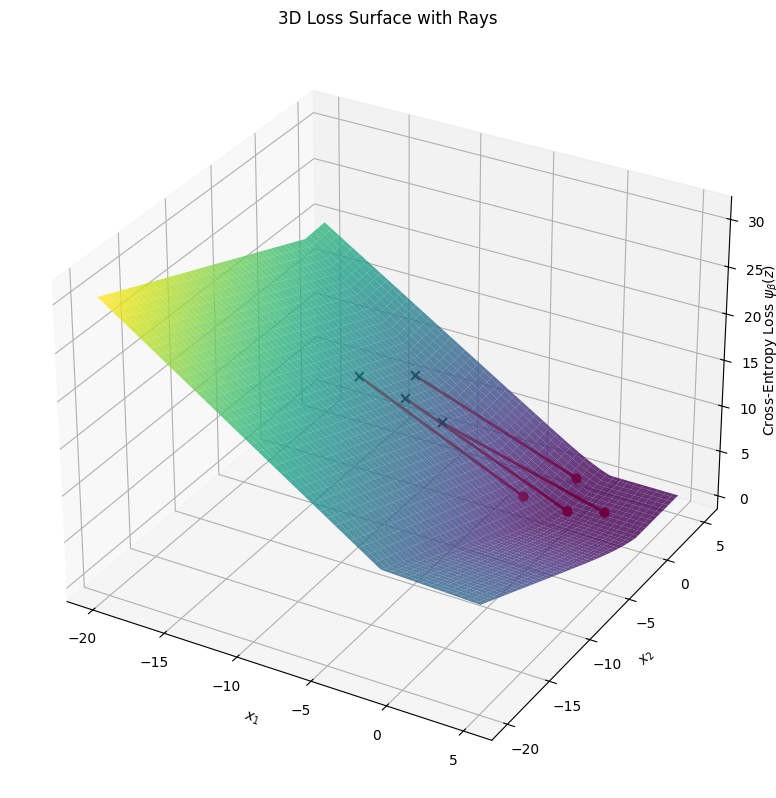

In [843]:
def psi_beta(z):
    z_proj = W2 @ np.maximum(W1 @ z, 0.0)
    p = np.exp(z_proj - np.max(z_proj))
    p = p / p.sum()
    return -np.log(p[0])                  # assume class 0 is true

# ---------------------------------------------------------------------
# 1.  Create loss-surface grid
# ---------------------------------------------------------------------
grid = np.linspace(-20, 5, 150)
xx, yy   = np.meshgrid(grid, grid)
loss_vals = np.zeros_like(xx)

for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        z = np.array([xx[i, j], yy[i, j]])
        loss_vals[i, j] = psi_beta(z)

# ---------------------------------------------------------------------
# 2.  Define ray start/end points
# ---------------------------------------------------------------------
points = np.array([
    [-2, -2],
    [ 0,  0],
    [ 2,  1],
    [-1,  3]
])
T = 10.0                                # length of segment
ray_endpoints = points + T * u         # end points along direction u

z_starts = [psi_beta(p) for p in points]
z_ends   = [psi_beta(p) for p in ray_endpoints]

# ---------------------------------------------------------------------
# 3.  Plot
# ---------------------------------------------------------------------
fig = plt.figure(figsize=(12, 9))
ax  = fig.add_subplot(projection='3d')

ax.plot_surface(xx, yy, loss_vals,
                cmap='viridis',
                alpha=0.8,
                linewidth=0,
                antialiased=True)

# Rays
for start, end, z_s, z_e in zip(points, ray_endpoints, z_starts, z_ends):
    ax.plot([start[0], end[0]],
            [start[1], end[1]],
            [z_s,      z_e],
            color='red', lw=2)
    ax.scatter(start[0], start[1], z_s, color='red',   s=40)
    ax.scatter(end[0],   end[1],   z_e, color='black', marker='x', s=40)

# ---------------------------------------------------------------------
# 4.  Labels -- keep the *entire* z-axis title visible
# ---------------------------------------------------------------------
ax.set_title("3D Loss Surface with Rays")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

# Push the label away from the axis and prevent clipping
ax.set_zlabel(r"Cross-Entropy Loss $\psi_{\beta}(z)$", rotation=90, labelpad=-0.12)
ax.zaxis.set_rotate_label(False)       # leave horizontal for readability

# Give the canvas extra breathing room on the left
fig.subplots_adjust(left=0.18, right=0.96, top=0.92, bottom=0.08)

plt.show()

## Assumptions Check

### Random Weights

$$
\text{int}(\text{rec}(\mathcal C^*)) \text{ is non-empty and open in } \mathbb{R}^{n}
$$

| **Random data**                  | For every Monte-Carlo trial you draw two Gaussian weight matrices:<br>• `W1 ∈ ℝ^{n₁×n}`  and  • `W2 ∈ ℝ^{K×n₁}`                                                                        |
|--------------------------------| --------------------------------------------------------------------------------------------------------------------------|
| **Compute the “best” ReLU mask** | `compute_D_star` searches for the diagonal mask **D\*** that maximises ‖W₂ D W₁‖₂.<br>  – If *n₁* ≤ 12 it enumerates all 2^{n₁} masks.<br>  – Otherwise it samples 4 096 random masks. |
| **Deterministic Ω-test**         | Given *W₁* and **D\***, form a block matrix **B** whose rows are ±rows of W₁.  An LP checks feasibility of **B u ≥ 1**. Success ⇔ Ω contains an interior point.                        |

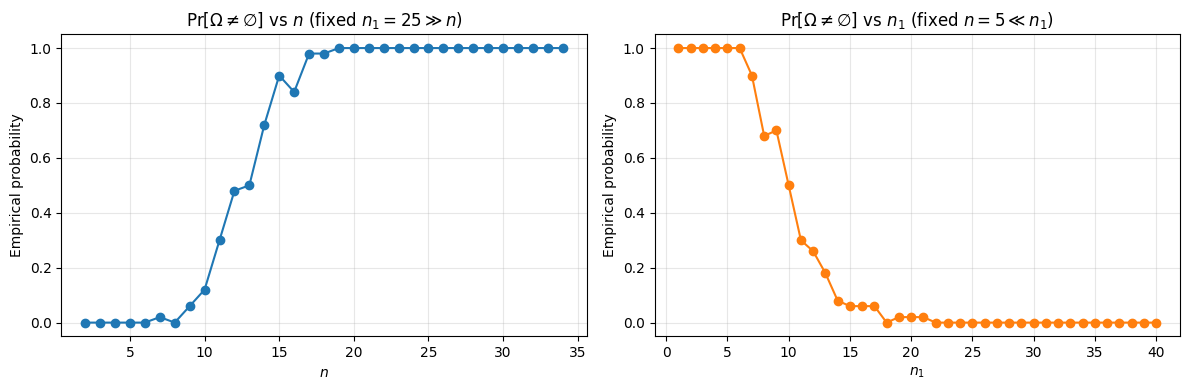

In [835]:
"""
Deterministic test of Assumption T2
----------------------------------
Ω := int( rec( C* ) ) ≠ ∅   ⇔   ∃ u  with  B u > 0,
where
    B = [ W1_i          ]_{i : (D*)_{ii}=1 }
        [ -W1_j ]_{j : (D*)_{jj}=0 }

The feasibility of  B u ≥ 1  is checked once via a linear-program (LP).
No random search in the cone is required.
"""
# ---------------------------------------------------------------------
# 1.  deterministic Ω–test
# ---------------------------------------------------------------------
def has_nonempty_omega(W1: np.ndarray, D_star: np.ndarray) -> bool:
    """Return True  ⇔  Ω = int(rec(C*)) is non-empty."""
    s = 2 * D_star.diagonal() - 1          # +1 (active) / −1 (inactive)
    B = s[:, None] * W1                    # rows are  ±W1_i
    m, n = B.shape

    # LP feasibility:  find u  s.t.  B u ≥ 1
    res = linprog(
        c=np.zeros(n),                     # dummy objective
        A_ub=-B,                           #  B u ≥ 1  ⟺  -B u ≤ -1
        b_ub=-np.ones(m),
        bounds=[(None, None)] * n,         # u free in ℝⁿ
        method="highs",
        options={"presolve": True},
    )
    return res.success


# ---------------------------------------------------------------------
# 2.  compute D*  (exact enumeration if n1 ≤ 12, else random search)
# ---------------------------------------------------------------------
def compute_D_star(W1: np.ndarray, W2: np.ndarray, nsamples: int = 4096):
    """
    Approximate argmax_D || W2 D W1 ||_2.

    •  If n1 ≤ 12, enumerate all 2^{n1} masks exactly.
    •  Otherwise, draw `nsamples` random masks.
    """
    n1 = W1.shape[0]
    best_norm, best_mask = -np.inf, None
    rng = np.random.default_rng()

    def masks():
        if n1 <= 12:
            for idx in range(1 << n1):
                yield np.array([(idx >> k) & 1 for k in range(n1)], dtype=float)
        else:
            for _ in range(nsamples):
                yield rng.integers(0, 2, n1).astype(float)

    for mask in masks():
        D = np.diag(mask)
        nrm = np.linalg.norm(W2 @ D @ W1, 2)
        if nrm > best_norm:
            best_norm, best_mask = nrm, mask

    return np.diag(best_mask)


# ---------------------------------------------------------------------
# 3.  empirical probability that T2 holds (deterministic Ω-test inside)
# ---------------------------------------------------------------------
def prob_T2(
    n: int,
    n1: int,
    K: int,
    trials: int = 1000,
    nsamples_D: int = 4096,
) -> float:
    """
    Monte-Carlo over random (W1, W2) with *deterministic* Ω-test.

    Returns empirical P[ Ω ≠ ∅ ].
    """
    good = 0
    rng = np.random.default_rng()

    for seed in range(trials):
        rng = np.random.default_rng(seed)
        W1 = rng.standard_normal((n1, n))
        W2 = rng.standard_normal((K, n1))
        D_star = compute_D_star(W1, W2, nsamples=nsamples_D)
        if has_nonempty_omega(W1, D_star):
            good += 1

    return good / trials


# ---------------------------------------------------------------------
# 4.  sweep the *extreme* regimes only
#     (i)  n  ≪ n1   :  fix a large n1, vary a much smaller n
#     (ii) n1 ≫ n    :  fix a small  n,  vary a much larger n1
# ---------------------------------------------------------------------
TRIALS       = 50
N_SAMPLES_D  = 4096

# (i)  n  ≪ n1
N1_LARGE        = 25                          # keep n1 fixed and large
N_SMALL_RANGE   = np.arange(2, N1_LARGE + 10)  # n ranges up to n1
P_vs_n_small    = [
    prob_T2(n, N1_LARGE, K=3, trials=TRIALS, nsamples_D=N_SAMPLES_D)
    for n in N_SMALL_RANGE
]

# (ii) n1 ≫ n
N_SMALL_FIXED   = 5
N1_LARGE_RANGE  = np.arange(1, 41)  # n1 ranges far past n
P_vs_n1_large   = [
    prob_T2(N_SMALL_FIXED, n1, K=3, trials=TRIALS, nsamples_D=N_SAMPLES_D)
    for n1 in N1_LARGE_RANGE
]

# ---------------------------------------------------------------------
# 5.  plot the two interesting curves
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# (i) n ≪ n1
axes[0].plot(N_SMALL_RANGE, P_vs_n_small, marker="o")
axes[0].set_title(r"$\Pr[\Omega\neq\varnothing]$ vs $n$ "
                  + rf"(fixed $n_1={N1_LARGE}\gg n$)")
axes[0].set_xlabel("$n$")
axes[0].set_ylabel("Empirical probability")
axes[0].grid(alpha=0.3)

# (ii) n1 ≫ n
axes[1].plot(N1_LARGE_RANGE, P_vs_n1_large, marker="o", color="tab:orange")
axes[1].set_title(r"$\Pr[\Omega\neq\varnothing]$ vs $n_1$ "
                  + rf"(fixed $n={N_SMALL_FIXED}\ll n_1$)")
axes[1].set_xlabel("$n_1$")
axes[1].set_ylabel("Empirical probability")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

$$
\text{rank}(J^*)=K
$$

| **Random weights**    | • `random_W1_full_rank` keeps resampling until W₁ has full rank min(n₁,n).<br>• W₂ is an unconstrained Gaussian.|
| - | - |
| **Mask search**           | Exhaustive if n₁ ≤ 10, else **1024** random masks per trial.|

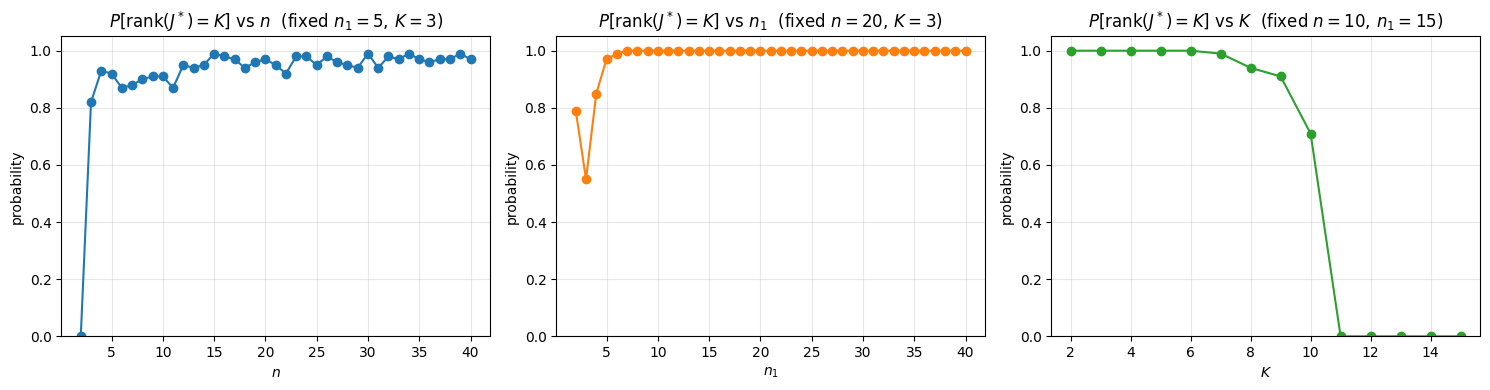

In [836]:
# ------------------------------------------------------------------ #
# 1. helpers                                                         #
# ------------------------------------------------------------------ #
def random_W1_full_rank(rng, n1: int, n: int) -> np.ndarray:
    """
    Gaussian W1 with full rank min(n1, n).  Works for both n1 ≤ n and n1 > n.
    """
    r_target = min(n1, n)
    while True:                              # (rank–deficiency has prob. 0,
        W1 = rng.standard_normal((n1, n))    #  loop exits almost immediately)
        if np.linalg.matrix_rank(W1) == r_target:
            return W1


def random_W2_any(rng, K: int, n1: int) -> np.ndarray:
    return rng.standard_normal((K, n1))


def spectral_norm(A: np.ndarray) -> float:
    return np.linalg.svd(A, compute_uv=False)[0]


def best_mask(W2, W1, rng, sample_masks="all"):
    """
    Return argmax_D || W2 D W1 ||_2.
      • if `sample_masks="all"` and n1≤10  ⇒ exhaustive search
      • else                              ⇒ random masks
    """
    n1 = W1.shape[0]
    best_val, D_star = -np.inf, None

    if sample_masks == "all":
        mask_iter = product([0, 1], repeat=n1)
    else:                                     # sample_masks = int (# of draws)
        mask_iter = (rng.integers(0, 2, size=n1) for _ in range(sample_masks))

    for bits in mask_iter:
        D = np.diag(bits)
        val = spectral_norm(W2 @ D @ W1)
        if val > best_val:
            best_val, D_star = val, D
    return D_star


# ------------------------------------------------------------------ #
# 2. Monte-Carlo estimator of P[ rank(J*) = K ]  (Assumption T3)      #
# ------------------------------------------------------------------ #
def prob_T3(n, n1, K, trials=1000, mask_sampling="all"):
    """
    Empirical  P[ rank(J*) = K ]  over random (W1, W2) pairs.
    No restriction on n1 versus n.
    """
    good = 0
    for seed in range(trials):
        rng  = np.random.default_rng(seed)
        W1   = random_W1_full_rank(rng, n1, n)        # full rank  min(n1, n)
        W2   = random_W2_any(rng, K, n1)              # unconstrained
        Dstar = best_mask(W2, W1, rng, mask_sampling)
        Jstar = W2 @ Dstar @ W1
        if np.linalg.matrix_rank(Jstar) == K:         # Assumption T3
            good += 1
    return good / trials


# ------------------------------------------------------------------ #
# 3. experiment settings                                             #
# ------------------------------------------------------------------ #
TRIALS        = 100             # MC repetitions per point
MASK_THRESH   = 10              # exhaustive masks if n1 ≤ 10
N_SAMPLES_D   = 1024            # random masks otherwise

# (1) vary n  with fixed n1 (n may be ≪ or ≫ n1)
N1_FIX, K_FIX = 5, 3
N_RANGE       = np.arange(2, 41)

# (2) vary n1 with fixed n (n1 may exceed n)
N_FIX, K_FIX2 = 20, 3
N1_RANGE      = np.arange(2, 41)

# (3) vary K  with fixed (n, n1)
N_FIX3, N1_FIX3 = 10, 15
K_RANGE         = np.arange(2, N1_FIX3 + 1)   # may exceed n ⇒ prob 0 for K>n


# ------------------------------------------------------------------ #
# 4. Monte-Carlo runs                                                #
# ------------------------------------------------------------------ #
prob_vs_n = [
    prob_T3(
        n, N1_FIX, K_FIX,
        trials=TRIALS,
        mask_sampling="all" if N1_FIX <= MASK_THRESH else N_SAMPLES_D
    )
    for n in N_RANGE
]

prob_vs_n1 = [
    prob_T3(
        N_FIX, n1, min(K_FIX2, n1, N_FIX),   # keep K ≤ min(n1, n)
        trials=TRIALS,
        mask_sampling="all" if n1 <= MASK_THRESH else N_SAMPLES_D
    )
    for n1 in N1_RANGE
]

prob_vs_K = [
    prob_T3(
        N_FIX3, N1_FIX3, K,
        trials=TRIALS,
        mask_sampling="all" if N1_FIX3 <= MASK_THRESH else N_SAMPLES_D
    )
    for K in K_RANGE
]


# ------------------------------------------------------------------ #
# 5. plots                                                           #
# ------------------------------------------------------------------ #
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# (1)  vs n
axes[0].plot(N_RANGE, prob_vs_n, marker='o')
axes[0].set_title(
    rf'$P[\operatorname{{rank}}(J^*)=K]$ vs $n$  '
    rf'(fixed $n_1={N1_FIX},\,K={K_FIX}$)'
)
axes[0].set_xlabel('$n$')
axes[0].set_ylabel('probability')
axes[0].grid(alpha=0.3)
axes[0].set_ylim(0, 1.05)

# (2)  vs n1
axes[1].plot(N1_RANGE, prob_vs_n1, marker='o', color='tab:orange')
axes[1].set_title(
    rf'$P[\operatorname{{rank}}(J^*)=K]$ vs $n_1$  '
    rf'(fixed $n={N_FIX},\,K={K_FIX2}$)'
)
axes[1].set_xlabel('$n_1$')
axes[1].set_ylabel('probability')
axes[1].grid(alpha=0.3)
axes[1].set_ylim(0, 1.05)

# (3)  vs K
axes[2].plot(K_RANGE, prob_vs_K, marker='o', color='tab:green')
axes[2].set_title(
    rf'$P[\operatorname{{rank}}(J^*)=K]$ vs $K$  '
    rf'(fixed $n={N_FIX3},\,n_1={N1_FIX3}$)'
)
axes[2].set_xlabel('$K$')
axes[2].set_ylabel('probability')
axes[2].grid(alpha=0.3)
axes[2].set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

| **Typical “wide layer” regime** | All experiments take **n₁ > n** because that’s the modern setting.                                                                                        |
| ------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Random weights**              | W₁ is resampled until it has full column rank n (because n₁ > n).  W₂ is Gaussian.                                                                        |
| **Mask search**                 | Same enumeration / random-sampling rule; random pool size **512** when needed.                                                                            |
| **Feasibility tests**           | • Check rank(J\*) = K.<br>• Solve a single LP (`satisfies_T4`) that enforces the directional equality in T4.<br>A trial is a “success” only if both pass. |

$$
\exists\,u\in\text{rec}(\mathcal C^*)\text{ with }
J^*u=\frac{\|J^*\|_2}{\sqrt2}(e_{j_+}-e_c)
$$

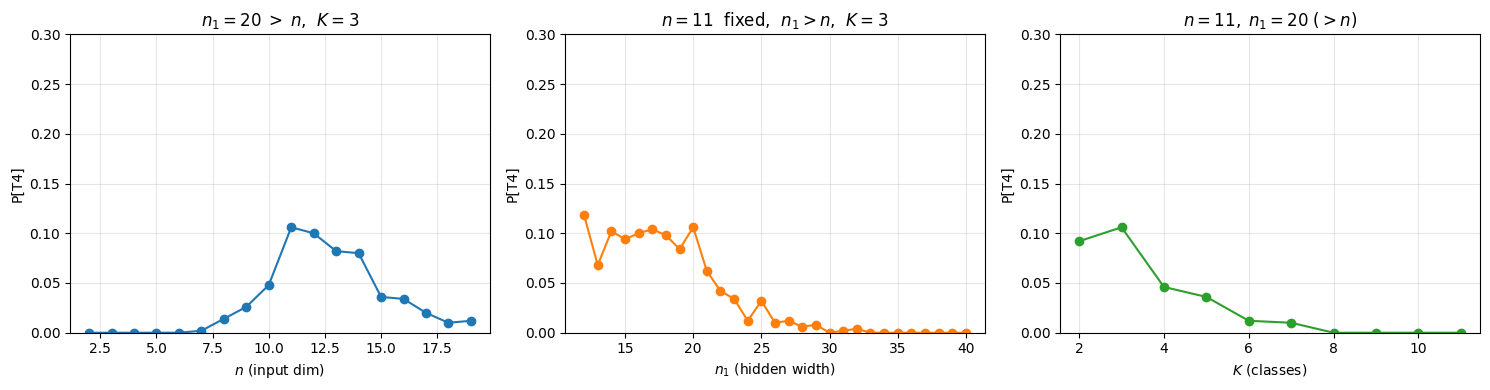

In [802]:
"""
Deterministic Monte-Carlo test for Assumption T4
*Now with the realistic regime  n₁ > n  everywhere.*
"""
# ------------------------------------------------------------------ #
# 1.  helper functions                                               #
# ------------------------------------------------------------------ #
def random_W1_full_rank(rng, n1: int, n: int) -> np.ndarray:
    """Gaussian W1 of shape (n1, n) having rank = n  (works for n1 > n)."""
    while True:
        W1 = rng.standard_normal((n1, n))
        if np.linalg.matrix_rank(W1) == n:   # full column rank
            return W1


def random_W2_any(rng, K: int, n1: int) -> np.ndarray:
    return rng.standard_normal((K, n1))


def spectral_norm(A: np.ndarray) -> float:
    return np.linalg.svd(A, compute_uv=False)[0]


def best_mask(W2, W1, rng, sample_masks="all"):
    """
    Arg-max over ReLU masks: D* = argmax_D ‖ W₂ D W₁ ‖₂.
    """
    n1 = W1.shape[0]
    if sample_masks == "all":
        mask_iter = product([0, 1], repeat=n1)
    else:
        mask_iter = (rng.integers(0, 2, size=n1) for _ in range(sample_masks))

    best_val, D_star = -np.inf, None
    for bits in mask_iter:
        D = np.diag(bits)
        val = spectral_norm(W2 @ D @ W1)
        if val > best_val:
            best_val, D_star = val, D
    return D_star


# ------------------------------------------------------------------ #
# 2.  deterministic feasibility for T4                               #
# ------------------------------------------------------------------ #
def satisfies_T4(W1, W2, D_star, J_star, c: int = 0) -> bool:
    """
    Check Assumption T4:
        ∃ u  in  rec(C*)   with   J* u = (‖J*‖₂ / √2) (e_{j+} − e_c).
    Feasibility solved as one LP.
    """
    K, _ = W2.shape
    n = W1.shape[1]
    J_norm = spectral_norm(J_star)

    # choose j+ ≠ c
    j_plus = 1 if c == 0 and K > 1 else 0
    if j_plus == c or K == 1:
        return False                     # degenerate output layer

    target = (J_norm / np.sqrt(2)) * (np.eye(K)[j_plus] - np.eye(K)[c])

    # build B  (face normals of recession cone)
    s = 2 * D_star.diagonal() - 1
    B = s[:, None] * W1
    m = B.shape[0]

    # decision vars  z = [u (n), t]
    c_vec = np.zeros(n + 1); c_vec[-1] = -1          # maximise t → minimise -t
    A_ub  = np.hstack([-B, np.ones((m, 1))])         # -B u + t ≤ 0  ⇒  B u ≥ t
    b_ub  = np.zeros(m)
    A_eq  = np.hstack([J_star, np.zeros((K, 1))])
    b_eq  = target
    bounds = [(None, None)] * n + [(0, None)]        # t ≥ 0

    res = linprog(c_vec, A_ub, b_ub, A_eq, b_eq, bounds,
                  method="highs", options={"presolve": True})
    return res.success and res.x[-1] > 1e-6          # strict interior


# ------------------------------------------------------------------ #
# 3.  Monte-Carlo estimator                                          #
# ------------------------------------------------------------------ #
def estimate_proportion(n, n1, K, *, trials=100, mask_sampling="all"):
    """
    Empirical P[T4] with n₁ > n allowed and typical in practice.
    """
    good = 0
    for seed in range(trials):
        rng = np.random.default_rng(seed)

        W1 = random_W1_full_rank(rng, n1, n)
        W2 = random_W2_any(rng, K, n1)

        D_star = best_mask(W2, W1, rng, mask_sampling)
        J_star = W2 @ D_star @ W1

        if np.linalg.matrix_rank(J_star) == K and satisfies_T4(W1, W2, D_star, J_star):
            good += 1
    return good / trials


# ------------------------------------------------------------------ #
# 4.  experiment configuration  (n₁ always > n)                      #
# ------------------------------------------------------------------ #
TRIALS        = 500
MASK_LIMIT    = 10
RAND_MASKS    = 512

# (1) fix n₁ large, vary smaller n (< n₁)
N1_FIXED, K_FIXED = 20, 3
N_RANGE = np.arange(2, N1_FIXED)          # 2 … 19  (all < n₁)
prop_vs_n = [
    estimate_proportion(
        n, N1_FIXED, K_FIXED,
        trials=TRIALS,
        mask_sampling="all" if N1_FIXED <= MASK_LIMIT else RAND_MASKS,
    )
    for n in N_RANGE
]

# (2) fix n small, let n₁ grow (n₁ > n always)
N_FIXED, K_FIXED2 = 11, 3
N1_RANGE = np.arange(N_FIXED + 1, 41)     # 11 … 40
prop_vs_n1 = [
    estimate_proportion(
        N_FIXED, n1, min(K_FIXED2, N_FIXED),   # keep K ≤ n
        trials=TRIALS,
        mask_sampling="all" if n1 <= MASK_LIMIT else RAND_MASKS,
    )
    for n1 in N1_RANGE
]

# (3) vary K with n₁ > n
N_FIXED3, N1_FIXED3 = 11, 20
K_RANGE = np.arange(2, N_FIXED3 + 1)      # up to n (rank cap)
prop_vs_K = [
    estimate_proportion(
        N_FIXED3, N1_FIXED3, K,
        trials=TRIALS,
        mask_sampling="all" if N1_FIXED3 <= MASK_LIMIT else RAND_MASKS,
    )
    for K in K_RANGE
]

# ------------------------------------------------------------------ #
# 5.  plots                                                          #
# ------------------------------------------------------------------ #
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(N_RANGE, prop_vs_n, marker='o')
axes[0].set_title(fr'$n_1={N1_FIXED}\;>\;n$,  $K={K_FIXED}$')
axes[0].set_xlabel('$n$ (input dim)')
axes[0].set_ylabel('P[T4]')

axes[1].plot(N1_RANGE, prop_vs_n1, marker='o', color='tab:orange')
axes[1].set_title(fr'$n={N_FIXED}$  fixed,  $n_1>n$,  $K={K_FIXED2}$')
axes[1].set_xlabel('$n_1$ (hidden width)')
axes[1].set_ylabel('P[T4]')

axes[2].plot(K_RANGE, prop_vs_K, marker='o', color='tab:green')
axes[2].set_title(fr'$n={N_FIXED3},\;n_1={N1_FIXED3}\;(>n)$')
axes[2].set_xlabel('$K$ (classes)')
axes[2].set_ylabel('P[T4]')

for ax in axes:
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 0.3)

plt.tight_layout()
plt.show()

### Optimized Weights

| Stage                   | What the code does|
| -| -|
| **Synthetic task**      | Draw a random “teacher” weight matrix $W_{\text{true}}\in\mathbb R^{K\times n}$. Generate $X\sim\mathcal N(0,I)$ ( `nsamp` samples) and noisy logits $W_{\text{true}}X$; labels $y$ are $\arg\max$. |
| **Training pass**       | Initialise $W_1\in\mathbb R^{n_1\times n},\;W_2\in\mathbb R^{K\times n_1}$ with i.i.d. Gaussians and run Adam for a few epochs of cross-entropy on that synthetic dataset.                          | 
| **Best mask $D^{\!*}$** | Search for the ReLU activation pattern that maximises $\lVert W_2 D W_1\rVert_2$.<br>• Exhaustive if $n_1\le10$ (“small net”).<br>• Else evaluate 1024 (or 512) random masks.                      | 

$$
\text{int}(\text{rec}(\mathcal C^*)) \text{ is non-empty and open in } \mathbb{R}^{n}
$$

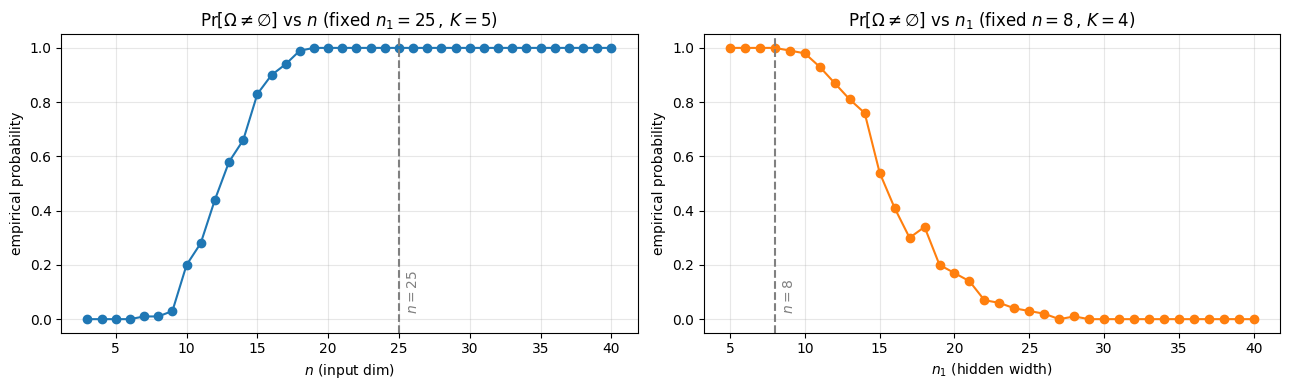

In [837]:
"""
Empirical test of
    Ω := int( rec(𝒞*) ) ≠ ∅       (full–dimensional recession cone)
with **trained** 2–layer ReLU networks (n₁ > n).

A single trial:
    1.  train W₁, W₂ on synthetic data
    2.  obtain D*  = argmax_D ‖W₂ D W₁‖₂
    3.  solve one LP  Bu ≥ t ,  J* u = 0   ( maximise t )
       ⇒  Ω ≠ ∅  ⇔  LP feasible with t>0
Repeat for Monte-Carlo proportion curves.
"""
# ---------------------------------------------------- utils
def set_seed(seed=0):
    torch.manual_seed(seed); np.random.seed(seed)

def spectral_norm(A):                    # ‖·‖₂
    return np.linalg.svd(A, compute_uv=False)[0]

# ---------------------------------------------------- (1) train 1-hidden-layer network
def train_network(n, n1, K,
                  *, nsamp=30, epochs=12, lr=1e-2,
                  seed=0, device="cpu"):
    set_seed(seed); device = torch.device(device)
    Wt = torch.randn(K, n, device=device)
    X  = torch.randn(nsamp, n, device=device)
    y  = torch.argmax(Wt @ X.T + 0.1*torch.randn(K,nsamp,device=device), dim=0)

    W1 = torch.randn(n1, n,   device=device, requires_grad=True)
    W2 = torch.randn(K,  n1,  device=device, requires_grad=True)
    opt = torch.optim.Adam([W1, W2], lr=lr)

    for _ in range(epochs):
        opt.zero_grad()
        h = F.relu(F.linear(X, W1))
        loss = F.cross_entropy(F.linear(h, W2), y); loss.backward(); opt.step()

    return W1.detach().cpu().numpy(), W2.detach().cpu().numpy()

# ---------------------------------------------------- (2) best mask  D*
def best_mask(W2, W1, rng, mask_policy="all", n_rand=1024):
    n1 = W1.shape[0]
    masks = (product([0,1], repeat=n1) if mask_policy=="all" and n1<=10
             else (rng.integers(0,2,size=n1) for _ in range(n_rand)))
    best, D_star = -np.inf, None
    for bits in masks:
        D = np.diag(bits); val = spectral_norm(W2 @ D @ W1)
        if val>best: best, D_star = val, D
    return D_star

# ---------------------------------------------------- (3) Ω-test by LP
def has_nonempty_omega(W1, D_star):
    s = 2*D_star.diagonal() - 1
    B = (s[:, None]) * W1              # m×n
    m, n = B.shape

    # max t  s.t.  Bu ≥ t  and  ∥u∥_∞ ≤ 1
    c = np.zeros(n+1);   c[-1] = -1         # minimise –t  ==  maximise t
    A_ub = np.vstack([
        np.hstack([-B,  np.ones((m,1))]),   # –Bu + t ≤ 0
        np.hstack([ np.eye(n), np.zeros((n,1))]),   #  u ≤ 1
        np.hstack([-np.eye(n), np.zeros((n,1))])    # –u ≤ 1
    ])
    b_ub = np.hstack([np.zeros(m), np.ones(n), np.ones(n)])
    bounds = [(None, None)]*n + [(0, None)]
    res = linprog(c, A_ub, b_ub, bounds=bounds, method='highs')
    return res.success and res.x[-1] > 1e-6

# ---------------------------------------------------- (4) single trial
def one_trial(n, n1, K, *, seed=0, mask_policy="all"):
    W1,W2 = train_network(n,n1,K,seed=seed)
    rng = np.random.default_rng(seed)
    D_star = best_mask(W2,W1,rng,mask_policy)
    return has_nonempty_omega(W1,D_star)

# ---------------------------------------------------- (5) Monte-Carlo proportion
def prop_Omega(n, n1, K, trials=30, mask_policy="all"):
    hits=0
    for s in range(trials):
        if one_trial(n,n1,K,seed=s,mask_policy=mask_policy): hits+=1
    return hits/trials

# ----------------------------------------------------  sweep Ω-probability
#
#  – left panel : fix n1 = 25  and let  n  run from 3 … 40
#                 (covers   n < n1   *and*   n > n1  in one curve)
#  – right panel: fix n  =  8  and let  n1 run from 5 … 40
#                 (covers   n1 < n   *and*   n1 > n)
# -------------------------------------------------------------------------
TRIALS = 100

# ------------------------  (a) vary n  (n may cross n1)  ---------------
n1_fixed, K_left = 25, 5
n_range = np.arange(3, 41)                          # 3 … 40
p_vs_n  = [prop_Omega(n, n1_fixed, K_left, TRIALS)  # Ω-probability
           for n in n_range]

# ------------------------  (b) vary n1 (n1 may cross n) -----------------
n_fixed, K_right = 8, 4
n1_range = np.arange(5, 41)                         # 5 … 40
p_vs_n1  = [prop_Omega(n_fixed, n1, K_right, TRIALS)
            for n1 in n1_range]

# ------------------------------------------------------------------------
#  plotting
# ------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# ---------- left: Ω-prob vs n  (vertical dashed line at n = n1) ----------
axes[0].plot(n_range, p_vs_n, marker='o')
axes[0].axvline(n1_fixed, ls='--', c='grey')
axes[0].text(n1_fixed + 0.5, 0.02, rf'$n={n1_fixed}$', rotation=90,
             va='bottom', ha='left', color='grey')
axes[0].set_title(rf'$\Pr[\Omega\neq\varnothing]$ vs $n$ '
                  rf'(fixed $n_1={n1_fixed}\,,\,K={K_left}$)')
axes[0].set_xlabel('$n$ (input dim)')
axes[0].set_ylabel('empirical probability')
axes[0].grid(alpha=0.3)

# ---------- right: Ω-prob vs n1 (vertical dashed line at n1 = n) ----------
axes[1].plot(n1_range, p_vs_n1, marker='o', color='tab:orange')
axes[1].axvline(n_fixed, ls='--', c='grey')
axes[1].text(n_fixed + 0.5, 0.02, rf'$n={n_fixed}$', rotation=90,
             va='bottom', ha='left', color='grey')
axes[1].set_title(rf'$\Pr[\Omega\neq\varnothing]$ vs $n_1$ '
                  rf'(fixed $n={n_fixed}\,,\,K={K_right}$)')
axes[1].set_xlabel('$n_1$ (hidden width)')
axes[1].set_ylabel('empirical probability')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

$$
\text{rank}(J^*)=K
$$

In [ ]:
"""
Monte-Carlo estimate of         rank(J*) = K
for trained 2-layer ReLU networks.

We draw three probability curves:

  (A)  vary n   (input dimension)          – fixed n₁, K
  (B)  vary n₁  (hidden width)             – fixed n,  K
  (C)  vary K   (output dimension / #classes) – fixed n, n₁

Only the **rank(J*) = K** property is plotted.
-----------------------------------------------------------------------
Dependencies:  numpy, torch, scipy, matplotlib
"""

# -------------------------------------------------------------------- #
#  Utilities
# -------------------------------------------------------------------- #
def set_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)


def spectral_norm(A: np.ndarray) -> float:
    return np.linalg.svd(A, compute_uv=False, hermitian=False)[0]


# -------------------------------------------------------------------- #
#  (1) train one-hidden-layer net
# -------------------------------------------------------------------- #
def train_network(n: int, n1: int, K: int,
                  *, nsamp=30, epochs=12, lr=1e-2,
                  seed=0, device="cpu"):
    set_seed(seed)
    device = torch.device(device)

    # synthetic classification task
    Wt = torch.randn(K, n, device=device)
    X  = torch.randn(nsamp, n, device=device)
    y  = torch.argmax(Wt @ X.T + 0.1*torch.randn(K, nsamp, device=device), dim=0)

    # parameters
    W1 = torch.randn(n1, n,  device=device, requires_grad=True)
    W2 = torch.randn(K,  n1, device=device, requires_grad=True)
    opt = torch.optim.Adam([W1, W2], lr=lr)

    for _ in range(epochs):
        opt.zero_grad()
        h = F.relu(F.linear(X, W1))
        loss = F.cross_entropy(F.linear(h, W2), y)
        loss.backward(); opt.step()

    return W1.detach().cpu().numpy(), W2.detach().cpu().numpy()


# -------------------------------------------------------------------- #
#  (2) choose activation mask  D*
# -------------------------------------------------------------------- #
def best_mask(W2: np.ndarray,
              W1: np.ndarray,
              rng: np.random.Generator,
              mask_policy="all",
              n_rand=1024):
    n1 = W1.shape[0]
    masks = (product([0, 1], repeat=n1)
             if mask_policy == "all" and n1 <= 10
             else (rng.integers(0, 2, size=n1) for _ in range(n_rand)))

    best, D_star = -np.inf, None
    for bits in masks:
        D = np.diag(bits)
        val = spectral_norm(W2 @ D @ W1)
        if val > best:
            best, D_star = val, D
    return D_star


# -------------------------------------------------------------------- #
#  (3) rank test
# -------------------------------------------------------------------- #
def rank_is_K(W2: np.ndarray,
              W1: np.ndarray,
              D_star: np.ndarray,
              K: int,
              tol: float = 1e-12) -> bool:
    J_star = W2 @ D_star @ W1
    return np.linalg.matrix_rank(J_star, tol=tol) == K


# -------------------------------------------------------------------- #
#  (4) single trial  –  rank only
# -------------------------------------------------------------------- #
def one_trial_rank(n: int, n1: int, K: int,
                   *, seed=0, mask_policy="all") -> bool:
    W1, W2 = train_network(n, n1, K, seed=seed)
    rng    = np.random.default_rng(seed)
    D_star = best_mask(W2, W1, rng, mask_policy)
    return rank_is_K(W2, W1, D_star, K)


# -------------------------------------------------------------------- #
#  (5) Monte-Carlo probability  Pr[ rank(J*) = K ]
# -------------------------------------------------------------------- #
def prop_rank(n: int, n1: int, K: int,
              trials=30, mask_policy="all") -> float:
    hits = 0
    for s in range(trials):
        if one_trial_rank(n, n1, K, seed=s, mask_policy=mask_policy):
            hits += 1
    return hits / trials


# -------------------------------------------------------------------- #
#  (6) sweeps and plot  (three curves)
# -------------------------------------------------------------------- #
TRIALS = 100                     # Monte-Carlo repetitions
MASK   = "all"                  # faster for large widths

# ---------------- (A) vary n  ----------------------------------- #
n1_A, K_A = 25, 5
n_range   = np.arange(3, 41)                 # 3 … 40
p_rank_vs_n = [prop_rank(n, n1_A, K_A,
                            trials=TRIALS, mask_policy=MASK)
                for n in n_range]

# ---------------- (B) vary n₁  ---------------------------------- #
n_B,  K_B = 8, 4
n1_range  = np.arange(5, 41)                 # 5 … 40
p_rank_vs_n1 = [prop_rank(n_B, n1, K_B,
                            trials=TRIALS, mask_policy=MASK)
                for n1 in n1_range]

# ---------------- (C) vary K  ----------------------------------- #
n_C, n1_C = 10, 25
K_range   = np.arange(2, n1_C + 1)            # 2 … n_C  (must have K ≤ n)
p_rank_vs_K = [prop_rank(n_C, n1_C, K,
                            trials=TRIALS, mask_policy=MASK)
                for K in K_range]


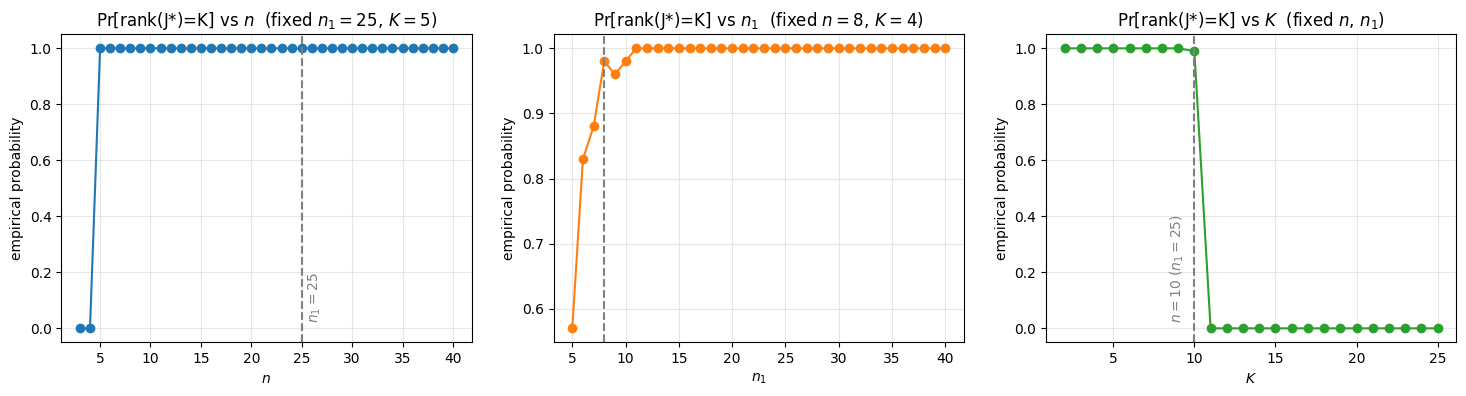

In [828]:

# ---------------------------------------------------------------- #
#  Plotting
# ---------------------------------------------------------------- #
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# (A) rank vs n
axes[0].plot(n_range, p_rank_vs_n, marker='o')
axes[0].axvline(n1_A, ls='--', c='grey')
axes[0].text(n1_A + 0.5, 0.02, rf'$n_1={n1_A}$',
                rotation=90, va='bottom', ha='left', color='grey')
axes[0].set_title(rf'Pr[rank(J*)=K] vs $n$  (fixed $n_1={n1_A},\,K={K_A}$)')
axes[0].set_xlabel('$n$')
axes[0].set_ylabel('empirical probability')
axes[0].grid(alpha=0.3)

# (B) rank vs n₁
axes[1].plot(n1_range, p_rank_vs_n1, marker='o', color='tab:orange')
axes[1].axvline(n_B, ls='--', c='grey')
axes[1].set_title(rf'Pr[rank(J*)=K] vs $n_1$  (fixed $n={n_B},\,K={K_B}$)')
axes[1].set_xlabel('$n_1$')
axes[1].set_ylabel('empirical probability')
axes[1].grid(alpha=0.3)

# (C) rank vs K
axes[2].plot(K_range, p_rank_vs_K, marker='o', color='tab:green')
axes[2].axvline(n_C, ls='--', c='grey')
axes[2].text(n_C - 0.5, 0.02, rf'$n={n_C}\;(n_1={n1_C})$',
                rotation=90, va='bottom', ha='right', color='grey')
axes[2].set_title(r'Pr[rank(J*)=K] vs $K$  (fixed $n$, $n_1$)')
axes[2].set_xlabel('$K$')
axes[2].set_ylabel('empirical probability')
axes[2].grid(alpha=0.3)

plt.show()

$$
\exists\,u\in\text{rec}(\mathcal C^*)\text{ with }
J^*u=\frac{\|J^*\|_2}{\sqrt2}(e_{j_+}-e_c)
$$

In [839]:
"""
Deterministic Monte-Carlo test of Assumption T4
    ∃ u ∈ rec(𝒞*) with J* u = ‖J*‖₂ / √2 · (e_{j+} − e_c)

–– now using **optimised (trained)** 2-layer ReLU networks instead of
random weight matrices.  Three probability curves are drawn:

  (A) vary n   (input dim)          – fixed n₁, K
  (B) vary n₁  (hidden width)       – fixed n, K
  (C) vary K   (output classes)     – fixed n, n₁

Dependencies : numpy, torch, scipy, matplotlib
"""

# ------------------------------------------------------------------ #
# 0. imports & helpers                                               #
# ------------------------------------------------------------------ #
import numpy as np
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt

from itertools import product
from scipy.optimize import linprog


def set_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)


def spectral_norm(A: np.ndarray) -> float:
    return np.linalg.svd(A, compute_uv=False, hermitian=False)[0]


# ------------------------------------------------------------------ #
# 1. train one-hidden-layer network                                  #
# ------------------------------------------------------------------ #
def train_network(n: int, n1: int, K: int,
                  *, nsamp=60, epochs=40, lr=5e-3,
                  seed=0, device="cpu"):
    """
    Returns (W1, W2) after simple SGD on a synthetic classification task.
    Shapes:  W1 (n1×n),  W2 (K×n1)
    """
    set_seed(seed)
    device = torch.device(device)

    # synthetic data
    Wt = torch.randn(K, n, device=device)
    X  = torch.randn(nsamp, n, device=device)
    y  = torch.argmax(Wt @ X.T + 0.1*torch.randn(K, nsamp, device=device), dim=0)

    # parameters
    W1 = torch.randn(n1, n,  device=device, requires_grad=True)
    W2 = torch.randn(K,  n1, device=device, requires_grad=True)
    opt = torch.optim.Adam([W1, W2], lr=lr)

    for _ in range(epochs):
        opt.zero_grad()
        h      = F.relu(F.linear(X, W1))
        logits = F.linear(h, W2)
        loss   = F.cross_entropy(logits, y)
        loss.backward(); opt.step()

    return W1.detach().cpu().numpy(), W2.detach().cpu().numpy()


# ------------------------------------------------------------------ #
# 2. best ReLU mask  D*                                              #
# ------------------------------------------------------------------ #
def best_mask(W2: np.ndarray,
              W1: np.ndarray,
              rng: np.random.Generator,
              sample_masks="all",
              n_rand: int = 1024):
    """
    D* = argmax_D ‖W₂ D W₁‖₂   (search exhaustively if small, else random).
    """
    n1 = W1.shape[0]

    if sample_masks == "all":
        mask_iter = product([0, 1], repeat=n1)
    else:                         # sample_masks is an int
        mask_iter = (rng.integers(0, 2, size=n1) for _ in range(sample_masks))

    best_val, D_star = -np.inf, None
    for bits in mask_iter:
        D = np.diag(bits)
        val = spectral_norm(W2 @ D @ W1)
        if val > best_val:
            best_val, D_star = val, D
    return D_star


# ------------------------------------------------------------------ #
# 3. Assumption T4 feasibility test                                  #
# ------------------------------------------------------------------ #
def satisfies_T4(W1: np.ndarray,
                 W2: np.ndarray,
                 D_star: np.ndarray,
                 J_star: np.ndarray,
                 c: int = 0) -> bool:
    """
    Solve one LP to check
        ∃ u ∈ rec(𝒞*) : J* u = ‖J*‖₂ / √2 · (e_{j+} − e_c)
    """
    K, _ = W2.shape
    n    = W1.shape[1]
    J_norm = spectral_norm(J_star)

    if K < 2:                          # degenerate
        return False

    j_plus = 1 if c == 0 else 0
    target = (J_norm / np.sqrt(2)) * (np.eye(K)[j_plus] - np.eye(K)[c])

    # recession cone faces
    s = 2 * D_star.diagonal() - 1
    B = s[:, None] * W1
    m = B.shape[0]

    # decision vars z = [u(n), t]
    c_vec = np.zeros(n + 1); c_vec[-1] = -1

    A_ub = np.hstack([-B,  np.ones((m, 1))])   # –Bu + t ≤ 0
    b_ub = np.zeros(m)
    A_eq = np.hstack([J_star, np.zeros((K, 1))])
    b_eq = target
    bounds = [(None, None)] * n + [(0, None)]   # t ≥ 0

    res = linprog(c_vec, A_ub, b_ub, A_eq, b_eq,
                  bounds=bounds, method="highs",
                  options={"presolve": True})
    return res.success and res.x[-1] > 1e-6


# ------------------------------------------------------------------ #
# 4. Monte-Carlo estimator                                           #
# ------------------------------------------------------------------ #
def estimate_proportion(n: int, n1: int, K: int,
                        *, trials=100, mask_sampling="all",
                        nsamp=60, epochs=40):
    good = 0
    for seed in range(trials):
        rng = np.random.default_rng(seed)

        W1, W2 = train_network(n, n1, K,
                               nsamp=nsamp, epochs=epochs,
                               seed=seed)

        D_star = best_mask(W2, W1, rng, mask_sampling)
        J_star = W2 @ D_star @ W1

        if np.linalg.matrix_rank(J_star) == K and \
           satisfies_T4(W1, W2, D_star, J_star):
            good += 1
    return good / trials


# ------------------------------------------------------------------ #
# 5. experiment setup                                                #
# ------------------------------------------------------------------ #
TRIALS      = 100
MASK_LIMIT  = 10
RAND_MASKS  = 512

# (A) vary n   (n₁ fixed > n)
N1_FIXED, K_FIXED = 20, 3
N_RANGE = np.arange(2, N1_FIXED + 10)
prop_vs_n = [
    estimate_proportion(
        n, N1_FIXED, K_FIXED,
        trials=TRIALS,
        mask_sampling="all" if N1_FIXED <= MASK_LIMIT else RAND_MASKS,
    )
    for n in N_RANGE
]

# (B) vary n₁  (n fixed)
N_FIXED, K_FIXED2 = 10, 3
N1_RANGE = np.arange(1, 41)
prop_vs_n1 = [
    estimate_proportion(
        N_FIXED, n1, min(K_FIXED2, N_FIXED),
        trials=TRIALS,
        mask_sampling="all" if n1 <= MASK_LIMIT else RAND_MASKS,
    )
    for n1 in N1_RANGE
]

# (C) vary K   (n₁ > n fixed)
N_FIXED3, N1_FIXED3 = 10, 15
K_RANGE = np.arange(2, N_FIXED3 + 1)
prop_vs_K = [
    estimate_proportion(
        N_FIXED3, N1_FIXED3, K,
        trials=TRIALS,
        mask_sampling="all" if N1_FIXED3 <= MASK_LIMIT else RAND_MASKS,
    )
    for K in K_RANGE
]

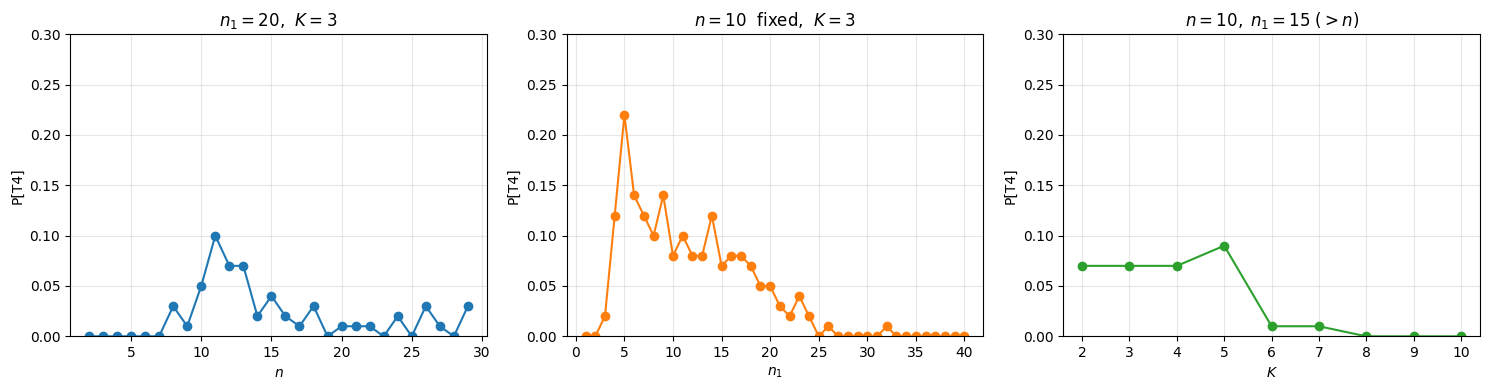

In [840]:

# ------------------------------------------------------------------ #
# 6. plots                                                           #
# ------------------------------------------------------------------ #
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(N_RANGE, prop_vs_n, marker='o')
axes[0].set_title(fr'$n_1={N1_FIXED}$,  $K={K_FIXED}$')
axes[0].set_xlabel('$n$');  axes[0].set_ylabel('P[T4]')
axes[0].grid(alpha=0.3);  axes[0].set_ylim(0, 0.3)

axes[1].plot(N1_RANGE, prop_vs_n1, marker='o', color='tab:orange')
axes[1].set_title(fr'$n={N_FIXED}$  fixed,  $K={K_FIXED2}$')
axes[1].set_xlabel('$n_1$');  axes[1].set_ylabel('P[T4]')
axes[1].grid(alpha=0.3);  axes[1].set_ylim(0, 0.3)

axes[2].plot(K_RANGE, prop_vs_K, marker='o', color='tab:green')
axes[2].set_title(fr'$n={N_FIXED3},\;n_1={N1_FIXED3}\;(>n)$')
axes[2].set_xlabel('$K$');  axes[2].set_ylabel('P[T4]')
axes[2].grid(alpha=0.3);  axes[2].set_ylim(0, 0.3)

plt.tight_layout()
plt.show()